In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from typing import Tuple, Optional

class LQR:
    def __init__(self, H: torch.Tensor, M: torch.Tensor, sigma: torch.Tensor, 
                 C: torch.Tensor, D: torch.Tensor, R: torch.Tensor, 
                 T: float, time_grid: torch.Tensor):
        """
        Initialize the LQR problem.
        
        Args:
            H: System dynamics matrix (d x d)
            M: Control input matrix (d x m)
            sigma: Noise matrix (d x d')
            C: State cost matrix (d x d)
            D: Control cost matrix (m x m)
            R: Terminal state cost matrix (d x d)
            T: Terminal time
            time_grid: Grid of time points
        """
        self.H = H
        self.M = M
        self.sigma = sigma
        self.C = C
        self.D = D
        self.R = R
        self.T = T
        self.time_grid = time_grid
        
        # Check dimensions
        d, m = M.shape
        assert H.shape == (d, d), "H must be d x d"
        assert sigma.shape[0] == d, "sigma must be d x d'"
        assert C.shape == (d, d), "C must be d x d"
        assert D.shape == (m, m), "D must be m x m"
        assert R.shape == (d, d), "R must be d x d"
        
        # Store dimensions
        self.d = d
        self.m = m
        
        # Compute inverse of D once for efficiency
        self.D_inv = torch.inverse(D)
        
        # Initialize solution placeholders
        self.S_grid = None  # Will be populated when solve_ricatti is called
        self.int_term_grid = None  # Will store the integral term
        
    def ricatti_rhs(self, t: float, S_flat: np.ndarray) -> np.ndarray:
        """
        Right-hand side of the Ricatti ODE: S'(t) = S(t)MD^(-1)M^TS(t) - H^TS(t) - S(t)H - C
        
        Args:
            t: Time
            S_flat: Flattened S matrix
            
        Returns:
            Flattened derivative of S
        """
        # Reshape S from flattened form
        S = torch.tensor(S_flat.reshape(self.d, self.d), dtype=torch.float64)
        
        # Compute right-hand side
        term1 = S @ self.M @ self.D_inv @ self.M.T @ S
        term2 = self.H.T @ S
        term3 = S @ self.H
        term4 = self.C
        
        # Compute derivative
        dS = term1 - term2 - term3 - term4
        
        # Return flattened result
        return dS.flatten().numpy()
    
    def solve_ricatti(self) -> None:
        """
        Solve the Ricatti ODE using scipy's solve_ivp for high accuracy.
        """
        # Convert matrices to double precision if they aren't already
        self.H = self.H.to(torch.float64)
        self.M = self.M.to(torch.float64)
        self.sigma = self.sigma.to(torch.float64)
        self.C = self.C.to(torch.float64)
        self.D = self.D.to(torch.float64)
        self.R = self.R.to(torch.float64)
        self.D_inv = self.D_inv.to(torch.float64)
        
        # Terminal condition: S(T) = R
        S_T_flat = self.R.flatten().numpy()
        
        # Time points for ODE solver (reversed for backward integration)
        t_points = self.time_grid.numpy()
        t_reversed = self.T - t_points[::-1]
        
        # Solve the ODE backward in time (from T to 0)
        solution = solve_ivp(
            lambda t, y: -self.ricatti_rhs(self.T - t, y),  # Negative for backward integration
            [0, self.T],
            S_T_flat,
            t_eval=t_reversed,
            method='RK45',
            rtol=1e-11,
            atol=1e-11
        )
        
        # Convert solution back to PyTorch tensors and reshape
        S_values = solution.y.T
        S_matrices = [S.reshape(self.d, self.d) for S in S_values]
        S_matrices.reverse()  # Reverse back to forward time
        
        self.S_grid = torch.tensor(S_matrices, dtype=torch.float64)
        
        # Compute integral term for value function
        self.compute_integral_term()
    
    def compute_integral_term(self) -> None:
        """
        Compute the integral term for the value function: int_t^T tr(sigma sigma^T S(r)) dr
        """
        if self.S_grid is None:
            self.solve_ricatti()
        
        # Compute trace term at each time point
        trace_terms = torch.zeros(len(self.time_grid))
        sigma_sigma_T = self.sigma @ self.sigma.T
        
        for i in range(len(self.time_grid)):
            trace_terms[i] = torch.trace(sigma_sigma_T @ self.S_grid[i])
        
        # Compute integral using trapezoidal rule (backward from T)
        integral_term = torch.zeros(len(self.time_grid))
        
        for i in range(len(self.time_grid) - 1, 0, -1):
            dt = self.time_grid[i] - self.time_grid[i-1]
            integral_term[i-1] = integral_term[i] + 0.5 * (trace_terms[i] + trace_terms[i-1]) * dt
        
        self.int_term_grid = integral_term
    
    def get_S_at_time(self, t: torch.Tensor) -> torch.Tensor:
        """
        Get the S matrix at a given time by finding the nearest time point in the grid.
        
        Args:
            t: Time tensor (batch)
            
        Returns:
            S matrices at the specified times (batch x d x d)
        """
        if self.S_grid is None:
            self.solve_ricatti()
            
        # Find indices of nearest time points for each t
        indices = torch.argmin(torch.abs(t.unsqueeze(1) - self.time_grid.unsqueeze(0)), dim=1)
        
        # Get the corresponding S matrices
        return self.S_grid[indices]
    
    def get_integral_term_at_time(self, t: torch.Tensor) -> torch.Tensor:
        """
        Get the integral term at a given time by finding the nearest time point in the grid.
        
        Args:
            t: Time tensor (batch)
            
        Returns:
            Integral terms at the specified times (batch)
        """
        if self.int_term_grid is None:
            self.compute_integral_term()
            
        # Find indices of nearest time points for each t
        indices = torch.argmin(torch.abs(t.unsqueeze(1) - self.time_grid.unsqueeze(0)), dim=1)
        
        # Get the corresponding integral terms
        return self.int_term_grid[indices]
    
    def value_function(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Compute the value function v(t, x) = x^T S(t) x + int_t^T tr(sigma sigma^T S(r)) dr
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x d)
            
        Returns:
            Value function at (t, x) (batch)
        """
        # Get S matrices at the specified times
        S_matrices = self.get_S_at_time(t)
        
        # Compute quadratic term x^T S(t) x
        batch_size = x.shape[0]
        values = torch.zeros(batch_size, device=x.device)
        
        for i in range(batch_size):
            values[i] = x[i] @ S_matrices[i] @ x[i]
        
        # Add integral term
        values = values + self.get_integral_term_at_time(t)
        
        return values
    
    def optimal_control(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Compute the optimal control a(t, x) = -D^(-1)M^TS(t)x
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x d)
            
        Returns:
            Optimal control at (t, x) (batch x m)
        """
        # Get S matrices at the specified times
        S_matrices = self.get_S_at_time(t)
        
        # Compute optimal control for each (t, x) pair
        batch_size = x.shape[0]
        controls = torch.zeros((batch_size, self.m), device=x.device)
        
        for i in range(batch_size):
            controls[i] = -self.D_inv @ self.M.T @ S_matrices[i] @ x[i]
        
        return controls

In [ ]:
def simulate_sde_explicit(lqr: LQR, x0: torch.Tensor, num_steps: int, num_samples: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Simulate the controlled SDE using the explicit scheme.
    
    Args:
        lqr: LQR instance
        x0: Initial state (batch x d)
        num_steps: Number of time steps
        num_samples: Number of Monte Carlo samples
        
    Returns:
        Tuple of (trajectory, cost)
    """
    dt = lqr.T / num_steps
    t_grid = torch.linspace(0, lqr.T, num_steps + 1, dtype=torch.float64)
    
    batch_size = x0.shape[0]
    d = lqr.d
    
    # Ensure all tensors are double precision
    H = lqr.H.to(torch.float64)
    M = lqr.M.to(torch.float64)
    sigma = lqr.sigma.to(torch.float64)
    C = lqr.C.to(torch.float64)
    D = lqr.D.to(torch.float64)
    
    # Initialize trajectories and costs
    X = torch.zeros((num_samples, batch_size, num_steps + 1, d), dtype=torch.float64)
    X[:, :, 0, :] = x0.unsqueeze(0).repeat(num_samples, 1, 1)
    
    costs = torch.zeros((num_samples, batch_size), dtype=torch.float64)
    
    # Generate Brownian increments
    dW = torch.randn((num_samples, batch_size, num_steps, sigma.shape[1]), dtype=torch.float64) * np.sqrt(dt)
    
    # Simulate trajectories
    for n in range(num_steps):
        t_n = t_grid[n]
        X_n = X[:, :, n, :]
        
        # Reshape for batch processing
        X_n_flat = X_n.reshape(-1, d)
        t_flat = t_n.repeat(num_samples * batch_size)
        
        # Compute optimal control
        control_flat = lqr.optimal_control(t_flat, X_n_flat).to(torch.float64)
        control = control_flat.reshape(num_samples, batch_size, lqr.m)
        
        # Compute drift and apply update for each sample
        for i in range(num_samples):
            for j in range(batch_size):
                # Compute drift term: HX + Ma
                drift = H @ X_n[i, j] + M @ control[i, j]
                
                # Update state using explicit scheme
                X[i, j, n+1] = X_n[i, j] + drift * dt + sigma @ dW[i, j, n]
                
                # Accumulate running cost
                state_cost = X_n[i, j] @ C @ X_n[i, j]
                control_cost = control[i, j] @ D @ control[i, j]
                costs[i, j] += (state_cost + control_cost) * dt
    
    # Add terminal cost
    X_T = X[:, :, -1, :]
    for i in range(num_samples):
        for j in range(batch_size):
            terminal_cost = X_T[i, j] @ lqr.R @ X_T[i, j]
            costs[i, j] += terminal_cost
    
    return X, costs

def simulate_sde_implicit(lqr: LQR, x0: torch.Tensor, num_steps: int, num_samples: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Simulate the controlled SDE using the implicit scheme.
    
    Args:
        lqr: LQR instance
        x0: Initial state (batch x d)
        num_steps: Number of time steps
        num_samples: Number of Monte Carlo samples
        
    Returns:
        Tuple of (trajectory, cost)
    """
    dt = lqr.T / num_steps
    t_grid = torch.linspace(0, lqr.T, num_steps + 1, dtype=torch.float64)
    
    batch_size = x0.shape[0]
    d = lqr.d
    
    # Ensure all tensors are double precision
    H = lqr.H.to(torch.float64)
    M = lqr.M.to(torch.float64)
    sigma = lqr.sigma.to(torch.float64)
    C = lqr.C.to(torch.float64)
    D = lqr.D.to(torch.float64)
    D_inv = lqr.D_inv.to(torch.float64)
    
    # Initialize trajectories and costs
    X = torch.zeros((num_samples, batch_size, num_steps + 1, d), dtype=torch.float64)
    X[:, :, 0, :] = x0.unsqueeze(0).repeat(num_samples, 1, 1)
    
    costs = torch.zeros((num_samples, batch_size), dtype=torch.float64)
    
    # Generate Brownian increments
    dW = torch.randn((num_samples, batch_size, num_steps, sigma.shape[1]), dtype=torch.float64) * np.sqrt(dt)
    
    # Identity matrix for linear system
    I = torch.eye(d, dtype=torch.float64)
    
    # Simulate trajectories
    for n in range(num_steps):
        t_n = t_grid[n]
        t_np1 = t_grid[n+1] 
        X_n = X[:, :, n, :]
        
        # Reshape for batch processing for cost calculation
        X_n_flat = X_n.reshape(-1, d)
        t_flat = t_n.repeat(num_samples * batch_size)
        
        # Compute optimal control for cost calculation
        control_flat = lqr.optimal_control(t_flat, X_n_flat).to(torch.float64)
        control = control_flat.reshape(num_samples, batch_size, lqr.m)
        
        # For implicit scheme, we need to solve a linear system for each sample
        S_np1 = lqr.get_S_at_time(torch.tensor([t_np1], dtype=torch.float64))[0].to(torch.float64)
        
        # Construct system matrix: (I - dt*H + dt*M*D^(-1)*M^T*S(t_{n+1}))
        MD_inv_MT = M @ D_inv @ M.T
        A = I - dt * H + dt * MD_inv_MT @ S_np1
        
        for i in range(num_samples):
            for j in range(batch_size):
                # Compute right-hand side: X_n + sigma * dW_n
                b = X_n[i, j] + sigma @ dW[i, j, n]
                
                # Solve the linear system: A * X_{n+1} = b
                X[i, j, n+1] = torch.linalg.solve(A, b)
                
                # Accumulate running cost
                state_cost = X_n[i, j] @ C @ X_n[i, j]
                control_cost = control[i, j] @ D @ control[i, j]
                costs[i, j] += (state_cost + control_cost) * dt
    
    # Add terminal cost
    X_T = X[:, :, -1, :]
    for i in range(num_samples):
        for j in range(batch_size):
            terminal_cost = X_T[i, j] @ lqr.R @ X_T[i, j]
            costs[i, j] += terminal_cost
    
    return X, costs

def run_monte_carlo_tests(lqr: LQR, x0: torch.Tensor, scheme: str = 'explicit') -> None:
    """
    Run Monte Carlo tests for the LQR problem.
    
    Args:
        lqr: LQR instance
        x0: Initial states to test
        scheme: 'explicit' or 'implicit'
    """
    # 1. Test varying time steps with fixed number of samples
    num_samples = 2500 # should be 10k
    time_steps_list = [2**i for i in range(1, 10)] # should be up to 12
    time_step_errors = []
    
    # Compute true value function at t=0, x=x0
    t0 = torch.zeros(x0.shape[0], dtype=torch.float64)
    true_values = lqr.value_function(t0, x0)
    
    print(f"\n--- Testing convergence for {scheme} scheme ---")
    print("Varying time steps...")
    
    for num_steps in time_steps_list:
        print(f"Running with {num_steps} time steps...")
        
        # Run simulation with current parameters
        if scheme == 'explicit':
            _, costs = simulate_sde_explicit(lqr, x0, num_steps, num_samples)
        else:
            _, costs = simulate_sde_implicit(lqr, x0, num_steps, num_samples)
        
        # Compute mean cost
        mean_costs = costs.mean(dim=0)
        
        # Compute error
        error = torch.abs(mean_costs - true_values).mean().item()
        time_step_errors.append(error)
        
        print(f"  Error: {error:.6f}")
    
    # Plot time step convergence
    plt.figure(figsize=(10, 6))
    plt.loglog(time_steps_list, time_step_errors, 'o-', label=f'{scheme.capitalize()} Scheme')
    
    # Add trend line 
    if scheme == 'explicit':
        ref_line = [time_step_errors[0] * (time_steps_list[0] / n) for n in time_steps_list]
        plt.loglog(time_steps_list, ref_line, '--', label='O(1/N)')
    else:
        ref_line = [time_step_errors[0] * (time_steps_list[0] / n)**2 for n in time_steps_list]
        plt.loglog(time_steps_list, ref_line, '--', label='O(1/N²)')
    
    plt.xlabel('Number of Time Steps (N)')
    plt.ylabel('Mean Absolute Error')
    plt.title(f'Convergence with Varying Time Steps ({scheme.capitalize()} Scheme)')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # 2. Test varying number of samples with fixed number of time steps
    num_steps = 2500  # Large number for accuracy should be 10k
    sample_counts = [2 * 4**i for i in range(5)] # should be range(6)
    sample_errors = []
    
    print("\nVarying sample counts...")
    
    for num_samples in sample_counts:
        print(f"Running with {num_samples} samples...")
        
        # Run simulation with current parameters
        if scheme == 'explicit':
            _, costs = simulate_sde_explicit(lqr, x0, num_steps, num_samples)
        else:
            _, costs = simulate_sde_implicit(lqr, x0, num_steps, num_samples)
        
        # Compute mean cost
        mean_costs = costs.mean(dim=0)
        
        # Compute error
        error = torch.abs(mean_costs - true_values).mean().item()
        sample_errors.append(error)
        
        print(f"  Error: {error:.6f}")
    
    # Plot sample count convergence
    plt.figure(figsize=(10, 6))
    plt.loglog(sample_counts, sample_errors, 'o-', label=f'{scheme.capitalize()} Scheme')
    
    # Add trend line (should be O(1/sqrt(M)) for Monte Carlo)
    ref_line = [sample_errors[0] * np.sqrt(sample_counts[0] / n) for n in sample_counts]
    plt.loglog(sample_counts, ref_line, '--', label='O(1/√M)')
    
    plt.xlabel('Number of Monte Carlo Samples (M)')
    plt.ylabel('Mean Absolute Error')
    plt.title(f'Convergence with Varying Sample Counts ({scheme.capitalize()} Scheme)')
    plt.grid(True)
    plt.legend()
    plt.show()

def run_monte_carlo_comparison(lqr: LQR, x0: torch.Tensor) -> None:
    """
    Run Monte Carlo tests comparing explicit and implicit schemes on the same plots.
    
    Args:
        lqr: LQR instance
        x0: Initial states to test
    """
    # 1. Test varying time steps with fixed number of samples
    num_samples = 1000 # Should be 10k
    time_steps_list = [2**i for i in range(1, 10)] # Should be 12
    
    # Compute true value function at t=0, x=x0
    t0 = torch.zeros(x0.shape[0], dtype=torch.float64)
    true_values = lqr.value_function(t0, x0)
    
    # Arrays to store results for both schemes
    explicit_time_errors = []
    implicit_time_errors = []
    
    print("\n--- Testing convergence for both schemes with varying time steps ---")
    
    for num_steps in time_steps_list:
        print(f"Running with {num_steps} time steps...")
        
        # Run simulation with explicit scheme
        _, costs_explicit = simulate_sde_explicit(lqr, x0, num_steps, num_samples)
        mean_costs_explicit = costs_explicit.mean(dim=0)
        error_explicit = torch.abs(mean_costs_explicit - true_values).mean().item()
        explicit_time_errors.append(error_explicit)
        
        # Run simulation with implicit scheme
        _, costs_implicit = simulate_sde_implicit(lqr, x0, num_steps, num_samples)
        mean_costs_implicit = costs_implicit.mean(dim=0)
        error_implicit = torch.abs(mean_costs_implicit - true_values).mean().item()
        implicit_time_errors.append(error_implicit)
        
        print(f"  Explicit scheme error: {error_explicit:.6f}")
        print(f"  Implicit scheme error: {error_implicit:.6f}")
    
    # Plot time step convergence for both schemes on the same graph
    plt.figure(figsize=(10, 6))
    plt.loglog(time_steps_list, explicit_time_errors, 'o-', color='blue', label='Explicit Scheme')
    plt.loglog(time_steps_list, implicit_time_errors, 's-', color='red', label='Implicit Scheme')
    
    # Add reference lines for O(1/N) and O(1/N²) convergence
    ref_line_order1 = [explicit_time_errors[0] * (time_steps_list[0] / n) for n in time_steps_list]
    ref_line_order2 = [explicit_time_errors[0] * (time_steps_list[0] / n)**2 for n in time_steps_list]
    
    plt.loglog(time_steps_list, ref_line_order1, '--', color='blue', alpha=0.5, label='O(1/N)')
    plt.loglog(time_steps_list, ref_line_order2, '--', color='red', alpha=0.5, label='O(1/N²)')
    
    plt.xlabel('Number of Time Steps (N)')
    plt.ylabel('Mean Absolute Error')
    plt.title('Convergence with Varying Time Steps - Comparison of Schemes')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # 2. Test varying number of samples with fixed number of time steps
    num_steps = 1000  # Large number for accuracy should be 10k
    sample_counts = [2 * 4**i for i in range(5)] # Should be 6
    
    # Arrays to store results for both schemes
    explicit_sample_errors = []
    implicit_sample_errors = []
    
    print("\n--- Testing convergence for both schemes with varying sample counts ---")
    
    for num_samples in sample_counts:
        print(f"Running with {num_samples} samples...")
        
        # Run simulation with explicit scheme
        _, costs_explicit = simulate_sde_explicit(lqr, x0, num_steps, num_samples)
        mean_costs_explicit = costs_explicit.mean(dim=0)
        error_explicit = torch.abs(mean_costs_explicit - true_values).mean().item()
        explicit_sample_errors.append(error_explicit)
        
        # Run simulation with implicit scheme
        _, costs_implicit = simulate_sde_implicit(lqr, x0, num_steps, num_samples)
        mean_costs_implicit = costs_implicit.mean(dim=0)
        error_implicit = torch.abs(mean_costs_implicit - true_values).mean().item()
        implicit_sample_errors.append(error_implicit)
        
        print(f"  Explicit scheme error: {error_explicit:.6f}")
        print(f"  Implicit scheme error: {error_implicit:.6f}")
    
    # Plot sample count convergence for both schemes on the same graph
    plt.figure(figsize=(10, 6))
    plt.loglog(sample_counts, explicit_sample_errors, 'o-', color='blue', label='Explicit Scheme')
    plt.loglog(sample_counts, implicit_sample_errors, 's-', color='red', label='Implicit Scheme')
    
    # Add reference line for O(1/sqrt(M)) convergence (Monte Carlo rate)
    ref_line_mc = [explicit_sample_errors[0] * np.sqrt(sample_counts[0] / n) for n in sample_counts]
    plt.loglog(sample_counts, ref_line_mc, '--', color='green', label='O(1/√M)')
    
    plt.xlabel('Number of Monte Carlo Samples (M)')
    plt.ylabel('Mean Absolute Error')
    plt.title('Convergence with Varying Sample Counts - Comparison of Schemes')
    plt.grid(True)
    plt.legend()
    plt.show()

S(0):
 tensor([[ 0.3698, -0.1901],
        [-0.1901,  0.5432]], dtype=torch.float64)
S(T/2):
 tensor([[ 0.4916, -0.3262],
        [-0.3262,  0.7793]], dtype=torch.float64)
S(T):
 tensor([[10.,  3.],
        [ 3., 10.]], dtype=torch.float64)

Value function at t=0:
v(0, [1.0, 1.0]) = 0.782136
v(0, [2.0, 2.0]) = 2.380319

Optimal control at t=0:
u(0, [1.0, 1.0]) = [-1.2770086526870728, -5.199576377868652]
u(0, [2.0, 2.0]) = [-2.5540173053741455, -10.399152755737305]

--- Testing convergence for explicit scheme ---
Varying time steps...
Running with 2 time steps...
  Error: 5.045467
Running with 4 time steps...
  Error: 1.133618
Running with 8 time steps...
  Error: 0.491513
Running with 16 time steps...
  Error: 0.224379
Running with 32 time steps...
  Error: 0.103346
Running with 64 time steps...
  Error: 0.053396
Running with 128 time steps...
  Error: 0.024888
Running with 256 time steps...
  Error: 0.012114
Running with 512 time steps...
  Error: 0.004284


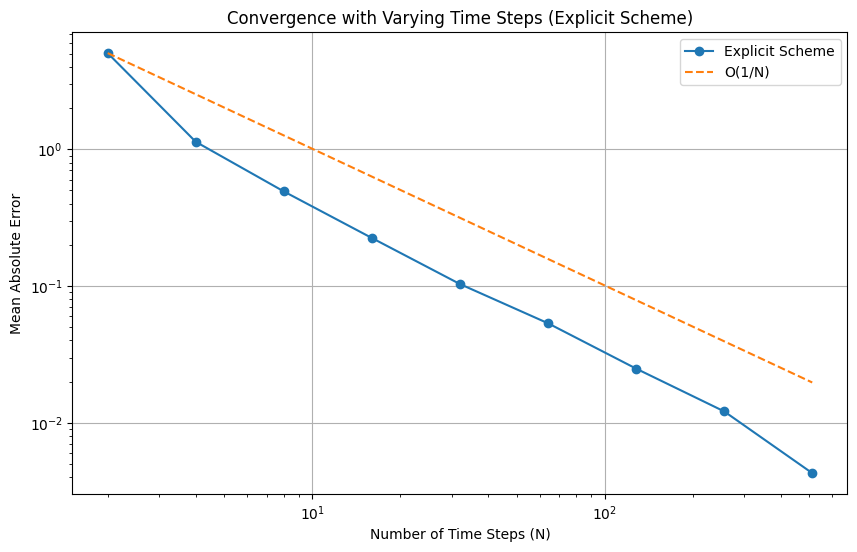


Varying sample counts...
Running with 2 samples...
  Error: 0.251542
Running with 8 samples...
  Error: 0.129240
Running with 32 samples...
  Error: 0.038412
Running with 128 samples...
  Error: 0.019944
Running with 512 samples...


KeyboardInterrupt: 

In [ ]:
def main_init():
    # Set the problem matrices as specified in Figure 1
    H = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64) * 0.5
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64)
    sigma = torch.eye(2, dtype=torch.float64) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 1.0
    D = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 0.1
    R = torch.tensor([[1.0, 0.3], [0.3, 1.0]], dtype=torch.float64) * 10.0

    # Set the terminal time and time grid
    T = 0.5
    grid_size = 1000
    time_grid = torch.linspace(0, T, grid_size, dtype=torch.float64)

    # Create LQR instance
    lqr = LQR(H, M, sigma, C, D, R, T, time_grid)

    # Solve Ricatti ODE
    lqr.solve_ricatti()

    # Print S matrices at key time points
    print("S(0):\n", lqr.S_grid[0])
    print("S(T/2):\n", lqr.S_grid[grid_size//2])
    print("S(T):\n", lqr.S_grid[-1])

    # Test points
    x0 = torch.tensor([
        [1.0, 1.0],
        [2.0, 2.0]
    ], dtype=torch.float64)

    # Compute value function at test points
    t0 = torch.zeros(x0.shape[0], dtype=torch.float64)
    v0 = lqr.value_function(t0, x0)
    print("\nValue function at t=0:")
    for i in range(x0.shape[0]):
        print(f"v(0, {x0[i].tolist()}) = {v0[i].item():.6f}")

    # Get the optimal control for the test points
    u0 = lqr.optimal_control(t0, x0)
    print("\nOptimal control at t=0:")
    for i in range(x0.shape[0]):
        print(f"u(0, {x0[i].tolist()}) = {u0[i].tolist()}")

    # Run Monte Carlo tests for explicit scheme
    run_monte_carlo_tests(lqr, x0, scheme='explicit')

    # Run Monte Carlo tests for implicit scheme
    run_monte_carlo_tests(lqr, x0, scheme='implicit')


In [ ]:
# main_init()

S(0):
 tensor([[ 0.3698, -0.1901],
        [-0.1901,  0.5432]], dtype=torch.float64)
S(T/2):
 tensor([[ 0.4916, -0.3262],
        [-0.3262,  0.7793]], dtype=torch.float64)
S(T):
 tensor([[10.,  3.],
        [ 3., 10.]], dtype=torch.float64)

Value function at t=0:
v(0, [1.0, 1.0]) = 0.782136
v(0, [2.0, 2.0]) = 2.380319

Optimal control at t=0:
u(0, [1.0, 1.0]) = [-1.2770086526870728, -5.199576377868652]
u(0, [2.0, 2.0]) = [-2.5540173053741455, -10.399152755737305]

--- Testing convergence for both schemes with varying time steps ---
Running with 2 time steps...
  Explicit scheme error: 4.944351
  Implicit scheme error: 2.352849
Running with 4 time steps...
  Explicit scheme error: 1.136594
  Implicit scheme error: 1.085881
Running with 8 time steps...
  Explicit scheme error: 0.489024
  Implicit scheme error: 0.482751
Running with 16 time steps...
  Explicit scheme error: 0.222731
  Implicit scheme error: 0.209865
Running with 32 time steps...
  Explicit scheme error: 0.104880
  Implic

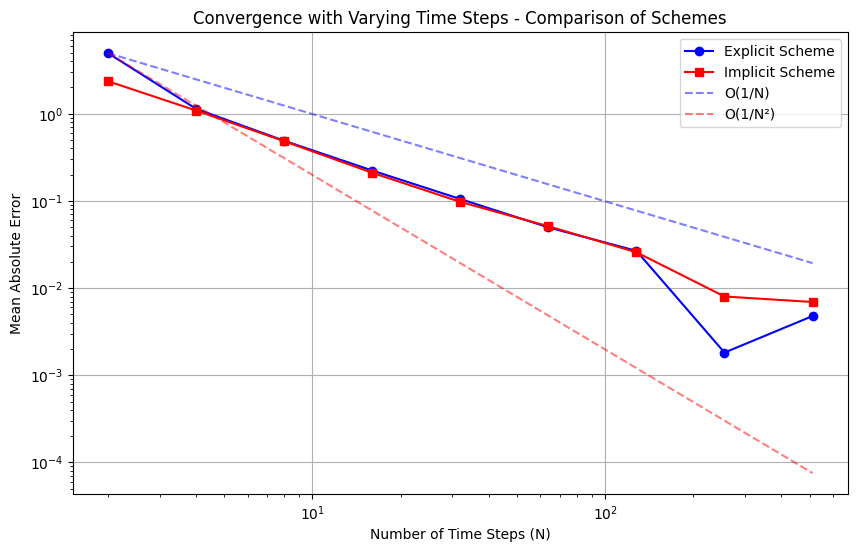


--- Testing convergence for both schemes with varying sample counts ---
Running with 2 samples...
  Explicit scheme error: 0.462984
  Implicit scheme error: 0.226043
Running with 8 samples...
  Explicit scheme error: 0.095107
  Implicit scheme error: 0.097713
Running with 32 samples...
  Explicit scheme error: 0.035934
  Implicit scheme error: 0.006308
Running with 128 samples...
  Explicit scheme error: 0.023574
  Implicit scheme error: 0.015609
Running with 512 samples...
  Explicit scheme error: 0.016939
  Implicit scheme error: 0.009918


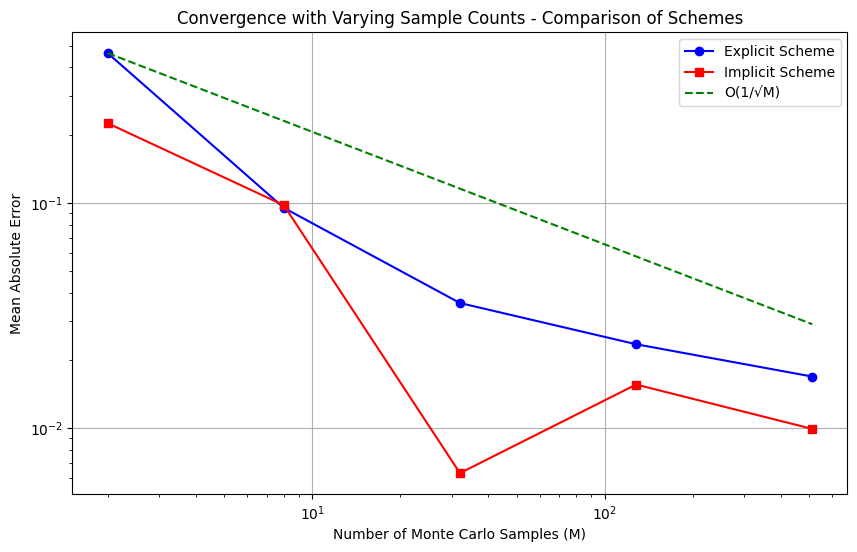

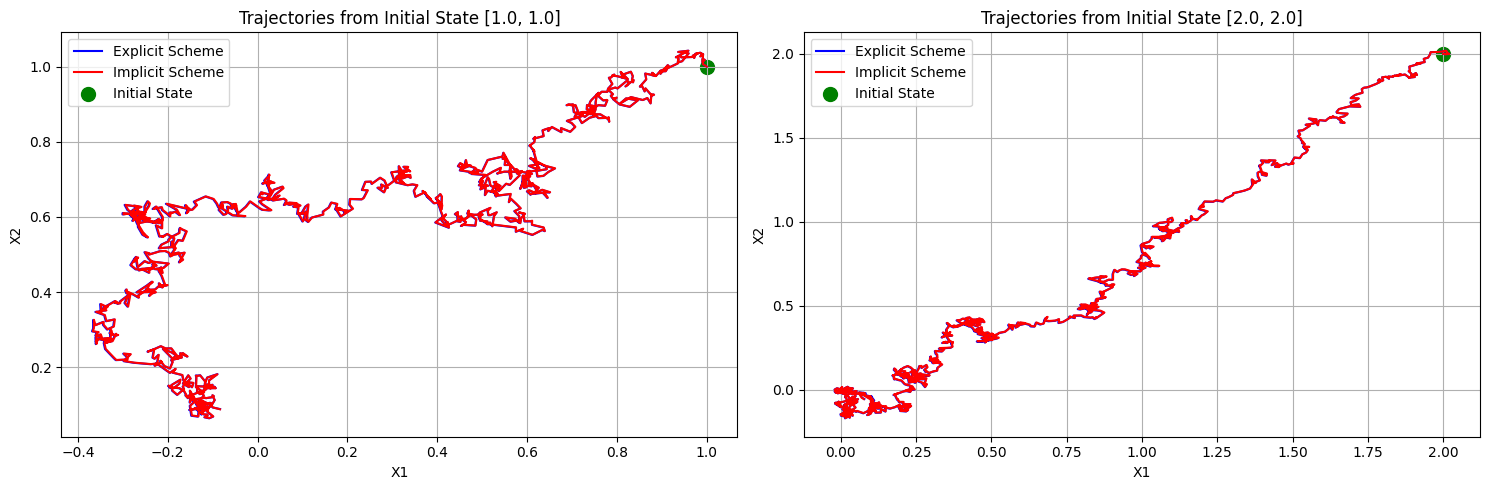

In [ ]:
def main():
    # Set the problem matrices as specified in Figure 1
    H = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64) * 0.5
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64)
    sigma = torch.eye(2, dtype=torch.float64) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 1.0
    D = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 0.1
    R = torch.tensor([[1.0, 0.3], [0.3, 1.0]], dtype=torch.float64) * 10.0
    
    # Set the terminal time and time grid
    T = 0.5
    grid_size = 1000
    time_grid = torch.linspace(0, T, grid_size, dtype=torch.float64)
    
    # Create LQR instance
    lqr = LQR(H, M, sigma, C, D, R, T, time_grid)
    
    # Solve Ricatti ODE
    lqr.solve_ricatti()
    
    # Print S matrices at key time points
    print("S(0):\n", lqr.S_grid[0])
    print("S(T/2):\n", lqr.S_grid[grid_size//2])
    print("S(T):\n", lqr.S_grid[-1])
    
    # Test points
    x0 = torch.tensor([
        [1.0, 1.0],
        [2.0, 2.0]
    ], dtype=torch.float64)
    
    # Compute value function at test points
    t0 = torch.zeros(x0.shape[0], dtype=torch.float64)
    v0 = lqr.value_function(t0, x0)
    print("\nValue function at t=0:")
    for i in range(x0.shape[0]):
        print(f"v(0, {x0[i].tolist()}) = {v0[i].item():.6f}")
    
    # Get the optimal control for the test points
    u0 = lqr.optimal_control(t0, x0)
    print("\nOptimal control at t=0:")
    for i in range(x0.shape[0]):
        print(f"u(0, {x0[i].tolist()}) = {u0[i].tolist()}")
    
    # Run Monte Carlo comparison for both schemes
    run_monte_carlo_comparison(lqr, x0)
    
    # Additionally, compare trajectories from both schemes
    compare_scheme_trajectories(lqr, x0)

def compare_scheme_trajectories(lqr: LQR, x0: torch.Tensor) -> None:
    """
    Compare and plot trajectories from explicit and implicit schemes.
    
    Args:
        lqr: LQR instance
        x0: Initial states to test
    """
    # Set simulation parameters
    num_steps = 100
    num_samples = 1  # Just one sample for visualization
    
    # Simulate trajectories using both schemes with the same noise
    # Generate Brownian motion for consistency between schemes
    dt = lqr.T / num_steps
    dW = torch.randn((num_samples, x0.shape[0], num_steps, lqr.sigma.shape[1]), 
                    dtype=torch.float64) * np.sqrt(dt)
    
    # Run simulations with shared noise
    X_explicit, _ = simulate_sde_explicit(lqr, x0, num_steps, num_samples, fixed_noise=dW)
    X_implicit, _ = simulate_sde_implicit(lqr, x0, num_steps, num_samples, fixed_noise=dW)
    
    # Plot trajectories for each initial state
    fig, axes = plt.subplots(1, x0.shape[0], figsize=(15, 5))
    
    for i in range(x0.shape[0]):
        ax = axes[i] if x0.shape[0] > 1 else axes
        
        # Extract trajectories for this initial state
        traj_explicit = X_explicit[0, i].cpu().numpy()  # First sample, ith initial state
        traj_implicit = X_implicit[0, i].cpu().numpy()
        
        # Plot trajectories
        ax.plot(traj_explicit[:, 0], traj_explicit[:, 1], 'b-', label='Explicit Scheme')
        ax.plot(traj_implicit[:, 0], traj_implicit[:, 1], 'r-', label='Implicit Scheme')
        ax.scatter([x0[i, 0]], [x0[i, 1]], c='g', s=100, marker='o', label='Initial State')
        
        ax.set_title(f'Trajectories from Initial State {x0[i].tolist()}')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Update the simulation functions to accept fixed noise
def simulate_sde_explicit(lqr: LQR, x0: torch.Tensor, num_steps: int, num_samples: int, 
                         fixed_noise: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Simulate the controlled SDE using the explicit scheme with optional fixed noise.
    
    Args:
        lqr: LQR instance
        x0: Initial state (batch x d)
        num_steps: Number of time steps
        num_samples: Number of Monte Carlo samples
        fixed_noise: Optional fixed Brownian increments for consistent comparisons
        
    Returns:
        Tuple of (trajectory, cost)
    """
    dt = lqr.T / num_steps
    t_grid = torch.linspace(0, lqr.T, num_steps + 1, dtype=torch.float64)
    
    batch_size = x0.shape[0]
    d = lqr.d
    
    # Ensure all tensors are double precision
    H = lqr.H.to(torch.float64)
    M = lqr.M.to(torch.float64)
    sigma = lqr.sigma.to(torch.float64)
    C = lqr.C.to(torch.float64)
    D = lqr.D.to(torch.float64)
    
    # Initialize trajectories and costs
    X = torch.zeros((num_samples, batch_size, num_steps + 1, d), dtype=torch.float64)
    X[:, :, 0, :] = x0.unsqueeze(0).repeat(num_samples, 1, 1)
    
    costs = torch.zeros((num_samples, batch_size), dtype=torch.float64)
    
    # Generate Brownian increments or use fixed ones
    if fixed_noise is None:
        dW = torch.randn((num_samples, batch_size, num_steps, sigma.shape[1]), 
                        dtype=torch.float64) * np.sqrt(dt)
    else:
        dW = fixed_noise
    
    # Simulate trajectories
    for n in range(num_steps):
        t_n = t_grid[n]
        X_n = X[:, :, n, :]
        
        # Reshape for batch processing
        X_n_flat = X_n.reshape(-1, d)
        t_flat = t_n.repeat(num_samples * batch_size)
        
        # Compute optimal control
        control_flat = lqr.optimal_control(t_flat, X_n_flat).to(torch.float64)
        control = control_flat.reshape(num_samples, batch_size, lqr.m)
        
        # Compute drift and apply update for each sample
        for i in range(num_samples):
            for j in range(batch_size):
                # Compute drift term: HX + Ma
                drift = H @ X_n[i, j] + M @ control[i, j]
                
                # Update state using explicit scheme
                X[i, j, n+1] = X_n[i, j] + drift * dt + sigma @ dW[i, j, n]
                
                # Accumulate running cost
                state_cost = X_n[i, j] @ C @ X_n[i, j]
                control_cost = control[i, j] @ D @ control[i, j]
                costs[i, j] += (state_cost + control_cost) * dt
    
    # Add terminal cost
    X_T = X[:, :, -1, :]
    for i in range(num_samples):
        for j in range(batch_size):
            terminal_cost = X_T[i, j] @ lqr.R @ X_T[i, j]
            costs[i, j] += terminal_cost
    
    return X, costs

def simulate_sde_implicit(lqr: LQR, x0: torch.Tensor, num_steps: int, num_samples: int,
                         fixed_noise: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Simulate the controlled SDE using the implicit scheme with optional fixed noise.
    
    Args:
        lqr: LQR instance
        x0: Initial state (batch x d)
        num_steps: Number of time steps
        num_samples: Number of Monte Carlo samples
        fixed_noise: Optional fixed Brownian increments for consistent comparisons
        
    Returns:
        Tuple of (trajectory, cost)
    """
    dt = lqr.T / num_steps
    t_grid = torch.linspace(0, lqr.T, num_steps + 1, dtype=torch.float64)
    
    batch_size = x0.shape[0]
    d = lqr.d
    
    # Ensure all tensors are double precision
    H = lqr.H.to(torch.float64)
    M = lqr.M.to(torch.float64)
    sigma = lqr.sigma.to(torch.float64)
    C = lqr.C.to(torch.float64)
    D = lqr.D.to(torch.float64)
    D_inv = lqr.D_inv.to(torch.float64)
    
    # Initialize trajectories and costs
    X = torch.zeros((num_samples, batch_size, num_steps + 1, d), dtype=torch.float64)
    X[:, :, 0, :] = x0.unsqueeze(0).repeat(num_samples, 1, 1)
    
    costs = torch.zeros((num_samples, batch_size), dtype=torch.float64)
    
    # Generate Brownian increments or use fixed ones
    if fixed_noise is None:
        dW = torch.randn((num_samples, batch_size, num_steps, sigma.shape[1]), 
                        dtype=torch.float64) * np.sqrt(dt)
    else:
        dW = fixed_noise
    
    # Identity matrix for linear system
    I = torch.eye(d, dtype=torch.float64)
    
    # Simulate trajectories
    for n in range(num_steps):
        t_n = t_grid[n]
        t_np1 = t_grid[n+1] 
        X_n = X[:, :, n, :]
        
        # Reshape for batch processing for cost calculation
        X_n_flat = X_n.reshape(-1, d)
        t_flat = t_n.repeat(num_samples * batch_size)
        
        # Compute optimal control for cost calculation
        control_flat = lqr.optimal_control(t_flat, X_n_flat).to(torch.float64)
        control = control_flat.reshape(num_samples, batch_size, lqr.m)
        
        # For implicit scheme, we need to solve a linear system for each sample
        S_np1 = lqr.get_S_at_time(torch.tensor([t_np1], dtype=torch.float64))[0].to(torch.float64)
        
        # Construct system matrix: (I - dt*H + dt*M*D^(-1)*M^T*S(t_{n+1}))
        MD_inv_MT = M @ D_inv @ M.T
        A = I - dt * H + dt * MD_inv_MT @ S_np1
        
        for i in range(num_samples):
            for j in range(batch_size):
                # Compute right-hand side: X_n + sigma * dW_n
                b = X_n[i, j] + sigma @ dW[i, j, n]
                
                # Solve the linear system: A * X_{n+1} = b
                X[i, j, n+1] = torch.linalg.solve(A, b)
                
                # Accumulate running cost
                state_cost = X_n[i, j] @ C @ X_n[i, j]
                control_cost = control[i, j] @ D @ control[i, j]
                costs[i, j] += (state_cost + control_cost) * dt
    
    # Add terminal cost
    X_T = X[:, :, -1, :]
    for i in range(num_samples):
        for j in range(batch_size):
            terminal_cost = X_T[i, j] @ lqr.R @ X_T[i, j]
            costs[i, j] += terminal_cost
    
    return X, costs

main()

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from typing import Tuple, Optional
import math

class SoftLQR(LQR):
    def __init__(self, H: torch.Tensor, M: torch.Tensor, sigma: torch.Tensor, 
                 C: torch.Tensor, D: torch.Tensor, R: torch.Tensor, 
                 T: float, time_grid: torch.Tensor,
                 tau: float, gamma: float):
        """
        Initialize the soft LQR problem with entropy regularization.
        
        Args:
            H: System dynamics matrix (d x d)
            M: Control input matrix (d x m)
            sigma: Noise matrix (d x d')
            C: State cost matrix (d x d)
            D: Control cost matrix (m x m)
            R: Terminal state cost matrix (d x d)
            T: Terminal time
            time_grid: Grid of time points
            tau: Entropy regularization strength
            gamma: Variance of prior normal density
        """
        super().__init__(H, M, sigma, C, D, R, T, time_grid)
        
        # Store additional parameters
        self.tau = tau
        self.gamma = gamma
        
        # Compute modified inverse term for the soft LQR
        # Σ⁻¹ = D + τ/(2γ²)I
        self.sigma_inv = self.D + (tau / (2 * gamma**2)) * torch.eye(self.m, dtype=self.D.dtype, device=self.D.device)
        self.sigma_term = torch.inverse(self.sigma_inv)
        
        # Compute determinant term for value function
        # C_D,τ,γ = -τ ln(τ^(m/2)/(γ^m * det(Σ)^(1/2)))
        self.CD_tau_gamma = -tau * math.log((tau**(self.m/2)) / (gamma**self.m * torch.sqrt(torch.det(self.sigma_term)).item()))

    def ricatti_rhs(self, t: float, S_flat: np.ndarray) -> np.ndarray:
        """
        Right-hand side of the modified Ricatti ODE for soft LQR:
        S'(t) = S(t)M(D + τ/(2γ²)I)^(-1)M^TS(t) - H^TS(t) - S(t)H - C
        
        Args:
            t: Time
            S_flat: Flattened S matrix
            
        Returns:
            Flattened derivative of S
        """
        # Reshape S from flattened form
        S = torch.tensor(S_flat.reshape(self.d, self.d), dtype=torch.float64)
        
        # Compute right-hand side with modified term
        term1 = S @ self.M @ self.sigma_term @ self.M.T @ S
        term2 = self.H.T @ S
        term3 = S @ self.H
        term4 = self.C
        
        # Compute derivative
        dS = term1 - term2 - term3 - term4
        
        # Return flattened result
        return dS.flatten().numpy()
    
    def compute_integral_term(self) -> None:
        """
        Compute the integral term for the value function: 
        int_t^T tr(sigma sigma^T S(r)) dr + (T-t) * C_D,τ,γ
        """
        if self.S_grid is None:
            self.solve_ricatti()
        
        # Compute trace term at each time point
        trace_terms = torch.zeros(len(self.time_grid))
        sigma_sigma_T = self.sigma @ self.sigma.T
        
        for i in range(len(self.time_grid)):
            trace_terms[i] = torch.trace(sigma_sigma_T @ self.S_grid[i])
        
        # Compute integral using trapezoidal rule (backward from T)
        integral_term = torch.zeros(len(self.time_grid))
        
        for i in range(len(self.time_grid) - 1, 0, -1):
            dt = self.time_grid[i] - self.time_grid[i-1]
            integral_term[i-1] = integral_term[i] + 0.5 * (trace_terms[i] + trace_terms[i-1]) * dt
        
        # Add the constant term proportional to (T-t)
        for i in range(len(self.time_grid)):
            integral_term[i] += (self.T - self.time_grid[i]) * self.CD_tau_gamma
        
        self.int_term_grid = integral_term
    
    def optimal_control_distribution(self, t: torch.Tensor, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute the parameters of the optimal control distribution:
        π*(·|t, x) = N(-(D + τ/(2γ²)I)^(-1)M^TS(t)x, τ(D + τ/(2γ²)I))
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x d)
            
        Returns:
            Tuple of (mean, covariance) of optimal control distribution
        """
        # Get S matrices at the specified times
        S_matrices = self.get_S_at_time(t)
        
        # Compute mean for each (t, x) pair
        batch_size = x.shape[0]
        means = torch.zeros((batch_size, self.m), dtype=torch.float64, device=x.device)
        
        for i in range(batch_size):
            means[i] = -self.sigma_term @ self.M.T @ S_matrices[i] @ x[i]
        
        # The covariance is constant for all (t, x)
        covariance = self.tau * self.sigma_term
        
        return means, covariance
    
    def optimal_control(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Sample from the optimal control distribution.
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x d)
            
        Returns:
            Sampled control actions (batch x m)
        """
        means, covariance = self.optimal_control_distribution(t, x)
        
        # Create multivariate normal distribution
        batch_size = means.shape[0]
        samples = torch.zeros_like(means)
        
        # Sample from the distribution
        L = torch.linalg.cholesky(covariance)  # Lower triangular Cholesky factor
        
        for i in range(batch_size):
            # Generate standard normal samples
            z = torch.randn(self.m, dtype=torch.float64, device=means.device)
            # Transform to multivariate normal with the required covariance
            samples[i] = means[i] + L @ z
        
        return samples

In [ ]:
# This would require installing torchdiffeq: pip install torchdiffeq
class GPUSoftLQR(SoftLQR):
    def solve_ricatti(self) -> None:
        """
        Solve the Ricatti ODE using torchdiffeq for GPU acceleration.
        """
        from torchdiffeq import odeint

        # Convert matrices to double precision and move to the proper device
        self.H = self.H.to(torch.float64, device=self.device)
        self.M = self.M.to(torch.float64, device=self.device)
        self.sigma = self.sigma.to(torch.float64, device=self.device)
        self.C = self.C.to(torch.float64, device=self.device)
        self.D = self.D.to(torch.float64, device=self.device)
        self.R = self.R.to(torch.float64, device=self.device)
        self.D_inv = self.D_inv.to(torch.float64, device=self.device)
        self.sigma_inv = self.sigma_inv.to(torch.float64, device=self.device)
        self.sigma_term = self.sigma_term.to(torch.float64, device=self.device)
        
        # Define RiccatiODE as a torch.nn.Module for torchdiffeq
        class RiccatiODE(torch.nn.Module):

            def __init__(self, H, M, sigma_term, C, d):
                super().__init__()
                self.H = H
                self.M = M
                self.sigma_term = sigma_term
                self.C = C
                self.d = d
            
            def forward(self, t, S_flat):
                # Reshape S from flattened form
                S = S_flat.reshape(self.d, self.d)
                
                # Compute right-hand side
                term1 = S @ self.M @ self.sigma_term @ self.M.T @ S
                term2 = self.H.T @ S
                term3 = S @ self.H
                term4 = self.C
                
                # Compute derivative
                dS = term1 - term2 - term3 - term4
                
                # Return flattened result
                return dS.flatten()
        
        # Create the ODE module
        ode_fn = RiccatiODE(
            self.H, self.M, self.sigma_term, self.C, self.d
        )
        
        # Terminal condition: S(T) = R
        S_T_flat = self.R.flatten()
        
        # Time points for ODE solver (reversed for backward integration)
        t_points = self.time_grid
        t_reversed = self.T - t_points.flip(0)
        
        # Solve the ODE backward in time (from T to 0) using torchdiffeq
        with torch.no_grad():
            S_solution = odeint(
                ode_fn, 
                S_T_flat, 
                t_reversed, 
                method='dopri5',
                rtol=1e-10, 
                atol=1e-10
            )
        
        # Reshape solution and reverse back to forward time
        S_matrices = S_solution.reshape(-1, self.d, self.d).flip(0)
        
        self.S_grid = S_matrices
        
        # Compute integral term for value function
        self.compute_integral_term()

In [23]:
def simulate_comparison(lqr: LQR, soft_lqr: SoftLQR, x0_list: list, num_steps: int, scheme: str = 'explicit') -> None:
    """
    Simulate and compare the standard LQR and soft LQR trajectories.
    
    Args:
        lqr: Standard LQR instance
        soft_lqr: Soft LQR instance
        x0_list: List of initial states to test
        num_steps: Number of time steps
        scheme: 'explicit' or 'implicit'
    """
    dt = lqr.T / num_steps
    t_grid = torch.linspace(0, lqr.T, num_steps + 1, dtype=torch.float64)
    
    # Ensure all matrices are double precision
    H = lqr.H.to(torch.float64)
    M = lqr.M.to(torch.float64)
    sigma = lqr.sigma.to(torch.float64)
    C = lqr.C.to(torch.float64)
    D = lqr.D.to(torch.float64)
    R = lqr.R.to(torch.float64)
    
    # Initialize plot
    fig, axes = plt.subplots(len(x0_list), 2, figsize=(16, 4*len(x0_list)))
    
    for i, x0 in enumerate(x0_list):
        # Convert initial state to tensor with explicit dtype
        x0_tensor = torch.tensor([x0], dtype=torch.float64)
        
        # Initialize trajectories and costs
        X_lqr = torch.zeros((num_steps + 1, 2), dtype=torch.float64)
        X_soft = torch.zeros((num_steps + 1, 2), dtype=torch.float64)
        X_lqr[0] = x0_tensor[0]
        X_soft[0] = x0_tensor[0]
        
        costs_lqr = torch.zeros(1, dtype=torch.float64)
        costs_soft = torch.zeros(1, dtype=torch.float64)
        
        # Generate same Brownian increments for both simulations
        dW = torch.randn((num_steps, sigma.shape[1]), dtype=torch.float64) * np.sqrt(dt)
        
        # For cost tracking
        running_costs_lqr = torch.zeros(num_steps + 1, dtype=torch.float64)
        running_costs_soft = torch.zeros(num_steps + 1, dtype=torch.float64)
        
        # Simulate trajectories
        if scheme == 'explicit':
            # Explicit scheme
            for n in range(num_steps):
                t_n = t_grid[n]
                t_tensor = torch.tensor([t_n], dtype=torch.float64)
                
                # Standard LQR step
                control_lqr = lqr.optimal_control(t_tensor, X_lqr[n:n+1])
                control_lqr = control_lqr.to(torch.float64)  # Ensure double precision
                drift_lqr = H @ X_lqr[n].to(torch.float64) + M @ control_lqr[0]
                X_lqr[n+1] = X_lqr[n] + drift_lqr * dt + sigma @ dW[n]
                
                # Compute running cost for LQR - using scalar operations to avoid dtype issues
                X_lqr_n_flat = X_lqr[n].to(torch.float64)
                C_float64 = C.to(torch.float64)
                D_float64 = D.to(torch.float64)
                
                state_cost_lqr = torch.matmul(torch.matmul(X_lqr_n_flat, C_float64), X_lqr_n_flat).item()
                control_cost_lqr = torch.matmul(torch.matmul(control_lqr[0], D_float64), control_lqr[0]).item()
                
                running_costs_lqr[n+1] = running_costs_lqr[n] + (state_cost_lqr + control_cost_lqr) * dt
                
                # Soft LQR step
                control_soft = soft_lqr.optimal_control(t_tensor, X_soft[n:n+1])
                control_soft = control_soft.to(torch.float64)  # Ensure double precision
                drift_soft = H @ X_soft[n].to(torch.float64) + M @ control_soft[0]
                X_soft[n+1] = X_soft[n] + drift_soft * dt + sigma @ dW[n]
                
                # Compute running cost for soft LQR (includes entropy term)
                X_soft_n_flat = X_soft[n].to(torch.float64)
                
                state_cost_soft = torch.matmul(torch.matmul(X_soft_n_flat, C_float64), X_soft_n_flat).item()
                control_cost_soft = torch.matmul(torch.matmul(control_soft[0], D_float64), control_soft[0]).item()
                
                # Add entropy regularization term
                means, covariance = soft_lqr.optimal_control_distribution(t_tensor, X_soft[n:n+1])
                means = means.to(torch.float64)
                covariance = covariance.to(torch.float64)
                entropy_term = soft_lqr.tau * torch.log(torch.det(2 * math.pi * math.e * covariance)).item() / 2
                
                running_costs_soft[n+1] = running_costs_soft[n] + (state_cost_soft + control_cost_soft + entropy_term) * dt
        else:
            # Implicit scheme
            # Identity matrix for linear system
            I = torch.eye(2, dtype=torch.float64)
            
            for n in range(num_steps):
                t_n = t_grid[n]
                t_np1 = t_grid[n+1]
                t_tensor = torch.tensor([t_n], dtype=torch.float64)
                t_np1_tensor = torch.tensor([t_np1], dtype=torch.float64)
                
                # Standard LQR
                control_lqr = lqr.optimal_control(t_tensor, X_lqr[n:n+1])
                control_lqr = control_lqr.to(torch.float64)  # Ensure double precision
                S_np1_lqr = lqr.get_S_at_time(t_np1_tensor)[0].to(torch.float64)
                D_inv_float64 = lqr.D_inv.to(torch.float64)
                A_lqr = I - dt * H + dt * M @ D_inv_float64 @ M.T @ S_np1_lqr
                b_lqr = X_lqr[n] + sigma @ dW[n]
                X_lqr[n+1] = torch.linalg.solve(A_lqr, b_lqr)
                
                # Compute running cost for LQR
                X_lqr_n_flat = X_lqr[n].to(torch.float64)
                C_float64 = C.to(torch.float64)
                D_float64 = D.to(torch.float64)
                
                state_cost_lqr = torch.matmul(torch.matmul(X_lqr_n_flat, C_float64), X_lqr_n_flat).item()
                control_cost_lqr = torch.matmul(torch.matmul(control_lqr[0], D_float64), control_lqr[0]).item()
                
                running_costs_lqr[n+1] = running_costs_lqr[n] + (state_cost_lqr + control_cost_lqr) * dt
                
                # Soft LQR
                control_soft = soft_lqr.optimal_control(t_tensor, X_soft[n:n+1])
                control_soft = control_soft.to(torch.float64)  # Ensure double precision
                S_np1_soft = soft_lqr.get_S_at_time(t_np1_tensor)[0].to(torch.float64)
                sigma_term_float64 = soft_lqr.sigma_term.to(torch.float64)
                A_soft = I - dt * H + dt * M @ sigma_term_float64 @ M.T @ S_np1_soft
                b_soft = X_soft[n] + sigma @ dW[n]
                X_soft[n+1] = torch.linalg.solve(A_soft, b_soft)
                
                # Compute running cost for soft LQR (includes entropy term)
                X_soft_n_flat = X_soft[n].to(torch.float64)
                
                state_cost_soft = torch.matmul(torch.matmul(X_soft_n_flat, C_float64), X_soft_n_flat).item()
                control_cost_soft = torch.matmul(torch.matmul(control_soft[0], D_float64), control_soft[0]).item()
                
                # Add entropy regularization term
                means, covariance = soft_lqr.optimal_control_distribution(t_tensor, X_soft[n:n+1])
                means = means.to(torch.float64)
                covariance = covariance.to(torch.float64)
                entropy_term = soft_lqr.tau * torch.log(torch.det(2 * math.pi * math.e * covariance)).item() / 2
                
                running_costs_soft[n+1] = running_costs_soft[n] + (state_cost_soft + control_cost_soft + entropy_term) * dt
        
        # Add terminal costs
        X_lqr_T = X_lqr[-1].to(torch.float64)
        X_soft_T = X_soft[-1].to(torch.float64)
        R_float64 = R.to(torch.float64)
        
        terminal_cost_lqr = torch.matmul(torch.matmul(X_lqr_T, R_float64), X_lqr_T).item()
        terminal_cost_soft = torch.matmul(torch.matmul(X_soft_T, R_float64), X_soft_T).item()
        
        running_costs_lqr[-1] += terminal_cost_lqr
        running_costs_soft[-1] += terminal_cost_soft
        
        # Total final costs
        costs_lqr = running_costs_lqr[-1]
        costs_soft = running_costs_soft[-1]
        
        # Plot trajectories
        ax1 = axes[i, 0] if len(x0_list) > 1 else axes[0]
        ax1.plot(X_lqr[:, 0].numpy(), X_lqr[:, 1].numpy(), 'b-', label='Standard LQR')
        ax1.plot(X_soft[:, 0].numpy(), X_soft[:, 1].numpy(), 'r-', label='Soft LQR')
        ax1.scatter([x0[0]], [x0[1]], color='g', s=100, marker='o', label='Initial State')
        ax1.set_title(f'Trajectories from Initial State {x0}')
        ax1.set_xlabel('X1')
        ax1.set_ylabel('X2')
        ax1.grid(True)
        ax1.legend()
        
        # Plot costs over time
        ax2 = axes[i, 1] if len(x0_list) > 1 else axes[1]
        ax2.plot(t_grid.numpy(), running_costs_lqr.numpy(), 'b-', label='Standard LQR Cost')
        ax2.plot(t_grid.numpy(), running_costs_soft.numpy(), 'r-', label='Soft LQR Cost')
        ax2.set_title(f'Cost Over Time from Initial State {x0}')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Cost')
        ax2.grid(True)
        ax2.legend()
        
        print(f"Initial state {x0}:")
        print(f"  Standard LQR final cost: {float(costs_lqr):.2f}")
        print(f"  Soft LQR final cost: {float(costs_soft):.2f}")
    
    plt.tight_layout()
    plt.show()

In [24]:
def main_soft_lqr():
    # Set the problem matrices as specified in Figure 1
    H = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64) * 0.5
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64)
    sigma = torch.eye(2, dtype=torch.float64) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 1.0
    D = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 0.1
    R = torch.tensor([[1.0, 0.3], [0.3, 1.0]], dtype=torch.float64) * 10.0
    
    # Set the terminal time and time grid
    T = 0.5
    grid_size = 1000
    time_grid = torch.linspace(0, T, grid_size, dtype=torch.float64)
    
    # Set entropy regularization parameters
    tau = 0.1
    gamma = 10.0
    
    # Create standard LQR instance
    lqr = LQR(H, M, sigma, C, D, R, T, time_grid)
    
    # Create soft LQR instance
    soft_lqr = SoftLQR(H, M, sigma, C, D, R, T, time_grid, tau, gamma)
    
    # Solve Ricatti ODEs
    lqr.solve_ricatti()
    soft_lqr.solve_ricatti()
    
    # Print S matrices at key time points
    print("Standard LQR S(0):\n", lqr.S_grid[0])
    print("Soft LQR S(0):\n", soft_lqr.S_grid[0])
    
    # Test points for trajectory comparison
    initial_states = [
        [2.0, 2.0],
        [2.0, -2.0],
        [-2.0, -2.0],
        [-2.0, 2.0]
    ]
    
    # Compare trajectories
    simulate_comparison(lqr, soft_lqr, initial_states, num_steps=200, scheme='explicit')

    

Standard LQR S(0):
 tensor([[ 0.3698, -0.1901],
        [-0.1901,  0.5432]], dtype=torch.float64)
Soft LQR S(0):
 tensor([[ 0.3711, -0.1911],
        [-0.1911,  0.5454]], dtype=torch.float64)
Initial state [2.0, 2.0]:
  Standard LQR final cost: 2.21
  Soft LQR final cost: 2.46
Initial state [2.0, -2.0]:
  Standard LQR final cost: 4.35
  Soft LQR final cost: 4.60
Initial state [-2.0, -2.0]:
  Standard LQR final cost: 2.63
  Soft LQR final cost: 2.88
Initial state [-2.0, 2.0]:
  Standard LQR final cost: 4.08
  Soft LQR final cost: 4.34


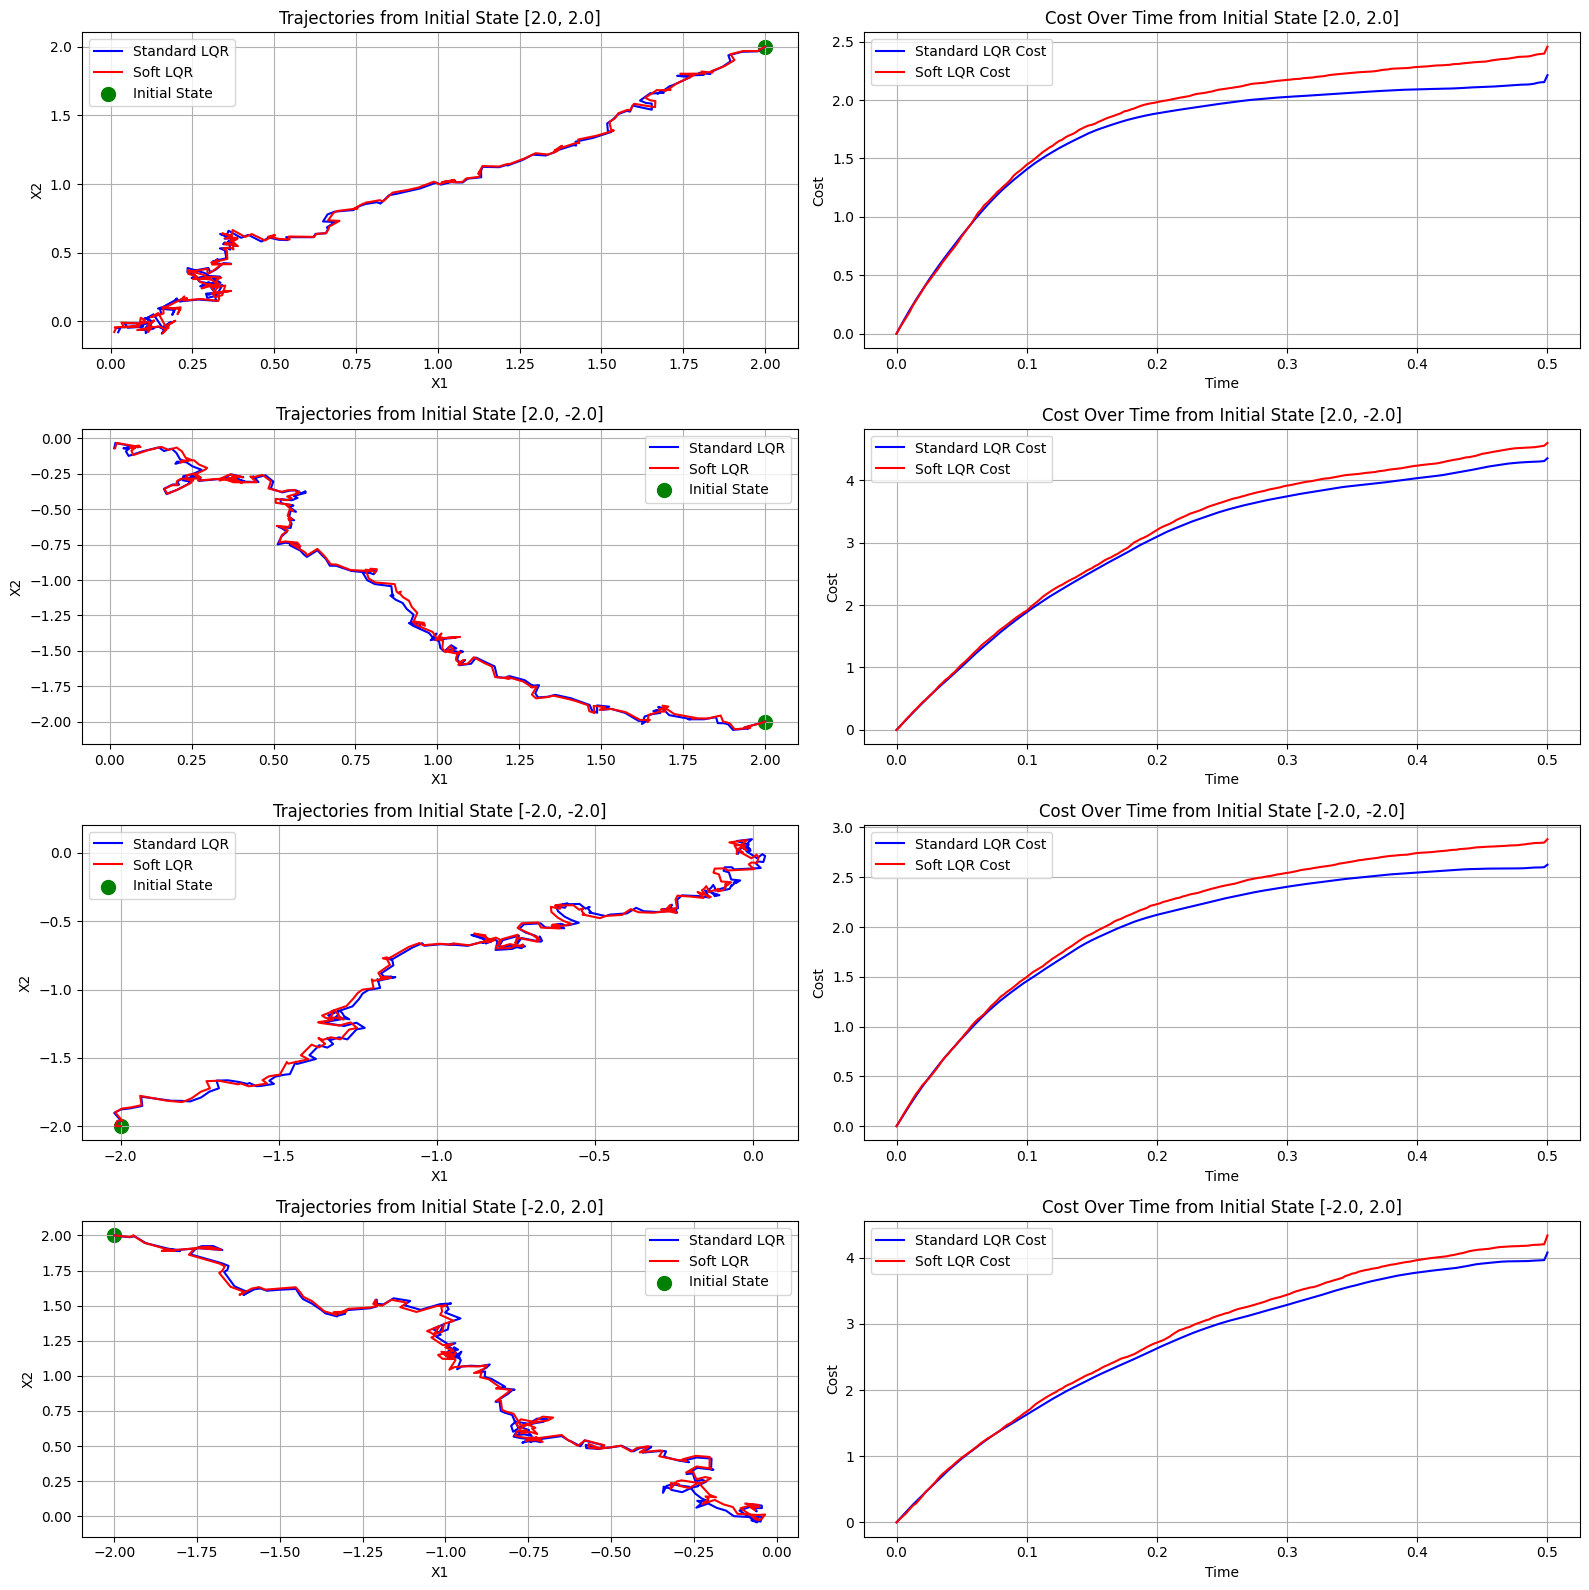

In [25]:
main_soft_lqr()

## Question 3

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
class ValueNetwork(nn.Module):
    def __init__(self, hidden_size=512, device="cpu", dtype=torch.float32):
        """
        Neural network to learn the value function for the soft LQR problem.
        
        Args:
            hidden_size: Size of the hidden layers
            device: Device to run the network on
            dtype: Data type for the network parameters (default: float32)
        """
        super(ValueNetwork, self).__init__()
        
        # Set device and dtype
        self.device = device
        self.dtype = dtype
        
        # Define layers
        self.hidden_layer1 = nn.Linear(1, hidden_size, device=device, dtype=dtype)
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size, device=device, dtype=dtype)
        
        # Output for the matrix (2x2 symmetric)
        self.matrix_output = nn.Linear(hidden_size, 2*2, device=device, dtype=dtype)
        
        # Output for the scalar offset
        self.offset_output = nn.Linear(hidden_size, 1, device=device, dtype=dtype)
    
    def forward(self, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through the network.
        
        Args:
            t: Time tensor (batch)
            
        Returns:
            Tuple of (matrix, offset) defining the value function
        """
        # Ensure input has the correct dtype
        t = t.to(self.dtype).to(self.device)
        
        # Reshape time to (batch, 1)
        t = t.view(-1, 1)
        
        # Forward pass through the hidden layers
        hidden = torch.relu(self.hidden_layer1(t))
        hidden = torch.relu(self.hidden_layer2(hidden))
        
        # Compute the matrix output
        matrix_elements = self.matrix_output(hidden)
        matrix = matrix_elements.view(-1, 2, 2)
        
        # Make the matrix positive semi-definite by product with transpose
        # A^T A is always positive semi-definite
        # Adding small constant to diagonal for stability
        eye = torch.eye(2, device=self.device, dtype=self.dtype).unsqueeze(0).repeat(matrix.shape[0], 1, 1)
        matrix = torch.bmm(matrix, matrix.transpose(1, 2)) + 1e-3 * eye
        
        # Compute the offset
        offset = self.offset_output(hidden)
        
        return matrix, offset
    
    def value_function(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Compute the value function v(t, x) = x^T S(t) x + b(t)
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x 2)
            
        Returns:
            Value function at (t, x) (batch)
        """
        # Ensure inputs have the correct dtype
        t = t.to(self.dtype).to(self.device)
        x = x.to(self.dtype).to(self.device)
        
        # Get the matrix and offset from the network
        S, b = self.forward(t)
        
        # Compute the quadratic term x^T S x
        batch_size = x.shape[0]
        values = torch.zeros(batch_size, device=self.device, dtype=self.dtype)
        
        for i in range(batch_size):
            values[i] = torch.matmul(torch.matmul(x[i], S[i]), x[i])
        
        # Add the offset term
        values = values + b.view(-1)
        
        return values

In [31]:
class CriticAlgorithm:
    def __init__(self, soft_lqr: SoftLQR, value_network: ValueNetwork, 
                 learning_rate: float = 1e-3, device: str = "cpu"):
        """
        Critic algorithm to learn the value function for a fixed policy.
        
        Args:
            soft_lqr: Soft LQR instance with the fixed policy
            value_network: Neural network to approximate the value function
            learning_rate: Learning rate for the optimizer
            device: Device to run the algorithm on
        """
        self.soft_lqr = soft_lqr
        self.value_network = value_network
        self.device = device
        
        # Store the network's data type
        self.dtype = self.value_network.dtype
        
        # Move soft_lqr matrices to the device
        self.soft_lqr.H = self.soft_lqr.H.to(device)
        self.soft_lqr.M = self.soft_lqr.M.to(device)
        self.soft_lqr.sigma = self.soft_lqr.sigma.to(device)
        self.soft_lqr.C = self.soft_lqr.C.to(device)
        self.soft_lqr.D = self.soft_lqr.D.to(device)
        self.soft_lqr.R = self.soft_lqr.R.to(device)
        self.soft_lqr.D_inv = self.soft_lqr.D_inv.to(device)
        self.soft_lqr.sigma_inv = self.soft_lqr.sigma_inv.to(device)
        self.soft_lqr.sigma_term = self.soft_lqr.sigma_term.to(device)
        if hasattr(self.soft_lqr, 'S_grid') and self.soft_lqr.S_grid is not None:
            self.soft_lqr.S_grid = self.soft_lqr.S_grid.to(device)
        if hasattr(self.soft_lqr, 'int_term_grid') and self.soft_lqr.int_term_grid is not None:
            self.soft_lqr.int_term_grid = self.soft_lqr.int_term_grid.to(device)
        
        # Setup optimizer
        self.optimizer = optim.Adam(self.value_network.parameters(), lr=learning_rate)
    
    def compute_episode_values(self, initial_states: torch.Tensor, num_steps: int, 
                              num_episodes: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Compute the true value function and Monte Carlo estimates for a batch of initial states.
        
        Args:
            initial_states: Initial states tensor (batch x 2)
            num_steps: Number of time steps for simulation
            num_episodes: Number of episodes for Monte Carlo estimation
            
        Returns:
            Tuple of (true_values, mc_estimates, states_trajectory)
        """
        # Ensure initial_states has the right data type for simulation
        initial_states = initial_states.to(torch.float64).to(self.device)
        
        batch_size = initial_states.shape[0]
        dt = self.soft_lqr.T / num_steps
        
        # Compute true value function at t=0, x=initial_states
        t0 = torch.zeros(batch_size, device=self.device, dtype=torch.float64)
        true_values = self.soft_lqr.value_function(t0, initial_states)
        
        # Initialize trajectories and accumulated costs
        states = torch.zeros((num_episodes, batch_size, num_steps + 1, 2), 
                             device=self.device, dtype=torch.float64)
        states[:, :, 0, :] = initial_states.unsqueeze(0).repeat(num_episodes, 1, 1)
        
        accumulated_costs = torch.zeros((num_episodes, batch_size), 
                                       device=self.device, dtype=torch.float64)
        
        # Generate time grid
        t_grid = torch.linspace(0, self.soft_lqr.T, num_steps + 1, 
                               device=self.device, dtype=torch.float64)
        
        # Generate Brownian increments
        dW = torch.randn((num_episodes, batch_size, num_steps, self.soft_lqr.sigma.shape[1]), 
                        device=self.device, dtype=torch.float64) * np.sqrt(dt)
        
        # Simulate trajectories using explicit scheme
        for n in range(num_steps):
            t_n = t_grid[n]
            t_flat = t_n.repeat(num_episodes * batch_size)
            
            # Reshape states for batch processing
            states_flat = states[:, :, n, :].reshape(-1, 2)
            
            # Get control means and covariance
            means, covariance = self.soft_lqr.optimal_control_distribution(t_flat, states_flat)
            means = means.to(torch.float64)
            covariance = covariance.to(torch.float64)
            means = means.reshape(num_episodes, batch_size, -1)
            
            # Sample controls
            controls = torch.zeros_like(means)
            L = torch.linalg.cholesky(covariance)
            
            for i in range(num_episodes):
                for j in range(batch_size):
                    # Generate standard normal samples
                    z = torch.randn(self.soft_lqr.m, device=self.device, dtype=torch.float64)
                    # Transform to multivariate normal
                    controls[i, j] = means[i, j] + torch.matmul(L, z)
            
            # Update states
            for i in range(num_episodes):
                for j in range(batch_size):
                    # Compute drift
                    drift = self.soft_lqr.H @ states[i, j, n] + self.soft_lqr.M @ controls[i, j]
                    
                    # Update state using explicit scheme
                    states[i, j, n+1] = states[i, j, n] + drift * dt + self.soft_lqr.sigma @ dW[i, j, n]
                    
                    # Compute running cost (state cost + control cost + entropy regularization)
                    state_cost = torch.matmul(torch.matmul(states[i, j, n], self.soft_lqr.C), states[i, j, n])
                    control_cost = torch.matmul(torch.matmul(controls[i, j], self.soft_lqr.D), controls[i, j])
                    
                    # Log probability density of the control under the policy
                    diff = controls[i, j] - means[i, j]
                    diff_reshaped = diff.unsqueeze(1)  # Make it a column vector
                    inv_cov = torch.inverse(covariance)
                    
                    # Compute quadratic term (a - μ)^T Σ^(-1) (a - μ)
                    quad_term = torch.matmul(torch.matmul(diff_reshaped.t(), inv_cov), diff_reshaped).item()
                    log_det_term = torch.log(torch.det(2 * np.pi * covariance)).item()
                    log_prob = -0.5 * (quad_term + log_det_term)
                    
                    # Entropy regularization term
                    entropy_term = self.soft_lqr.tau * (-log_prob)
                    
                    # Accumulate costs
                    accumulated_costs[i, j] += (state_cost + control_cost + entropy_term) * dt
        
        # Add terminal costs
        for i in range(num_episodes):
            for j in range(batch_size):
                terminal_cost = torch.matmul(torch.matmul(states[i, j, -1], self.soft_lqr.R), states[i, j, -1])
                accumulated_costs[i, j] += terminal_cost
        
        # Compute Monte Carlo estimates (mean over episodes)
        mc_estimates = accumulated_costs.mean(dim=0)
        
        return true_values, mc_estimates, states
    
    def train_step(self, initial_states_dist, num_states: int, num_steps: int, 
                  num_episodes: int) -> float:
        """
        Perform one training step of the critic algorithm.
        
        Args:
            initial_states_dist: Distribution to sample initial states from
            num_states: Number of initial states to sample
            num_steps: Number of time steps for simulation
            num_episodes: Number of episodes for Monte Carlo estimation
            
        Returns:
            Loss value for this step
        """
        # Sample initial states - use float64 for simulation
        initial_states = initial_states_dist.sample((num_states,)).to(torch.float64).to(self.device)
        
        # Compute true values and Monte Carlo estimates
        _, mc_estimates, states = self.compute_episode_values(
            initial_states, num_steps, num_episodes)
        
        # Initialize loss
        total_loss = 0.0
        
        # Generate time grid
        t_grid = torch.linspace(0, self.soft_lqr.T, num_steps + 1, device=self.device, dtype=torch.float64)
        
        # Compute loss for each time step
        for n in range(num_steps + 1):
            # Get time and states at this step - convert to network's dtype for prediction
            t_n = torch.ones(num_states, device=self.device, dtype=self.dtype) * (n * self.soft_lqr.T / num_steps)
            x_n = states[0, :, n, :].to(self.dtype)  # Use first episode for states
            
            # Compute value function prediction
            predicted_values = self.value_network.value_function(t_n, x_n)
            
            # Convert target to network's dtype
            target_values = mc_estimates.to(self.dtype)
            
            # Compute MSE loss
            step_loss = ((predicted_values - target_values) ** 2).mean()
            
            # Add to total loss
            total_loss += step_loss
        
        # Average loss over all time steps
        avg_loss = total_loss / (num_steps + 1)
        
        # Backpropagation
        self.optimizer.zero_grad()
        avg_loss.backward()
        self.optimizer.step()
        
        return avg_loss.item()
    
    def train(self, epochs: int, batch_size: int, num_steps: int, num_episodes: int, 
             initial_states_dist, eval_freq: int = 10, verbose: bool = True) -> List[float]:
        """
        Train the critic algorithm for multiple epochs.
        
        Args:
            epochs: Number of training epochs
            batch_size: Batch size (number of initial states) per epoch
            num_steps: Number of time steps for simulation
            num_episodes: Number of episodes for Monte Carlo estimation
            initial_states_dist: Distribution to sample initial states from
            eval_freq: Frequency of evaluation
            verbose: Whether to print progress
            
        Returns:
            List of loss values during training
        """
        losses = []
        
        for epoch in range(epochs):
            # Perform one training step
            loss = self.train_step(initial_states_dist, batch_size, num_steps, num_episodes)
            losses.append(loss)
            
            # Print progress
            if verbose and (epoch+1) % eval_freq == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4e}")
        
        return losses
    
    def evaluate(self, test_states: torch.Tensor, plot: bool = True) -> torch.Tensor:
        """
        Evaluate the trained value network against the true value function.
        
        Args:
            test_states: Test states tensor (batch x 2)
            plot: Whether to plot the results
            
        Returns:
            Tensor of errors
        """
        # Ensure test_states has correct dtype for true value calculation
        test_states_double = test_states.to(torch.float64).to(self.device)
        
        # Compute true value function at t=0, x=test_states
        batch_size = test_states.shape[0]
        t0 = torch.zeros(batch_size, device=self.device, dtype=torch.float64)
        true_values = self.soft_lqr.value_function(t0, test_states_double)
        
        # Convert states to network's dtype for prediction
        test_states_float = test_states.to(self.dtype).to(self.device)
        t0_float = torch.zeros(batch_size, device=self.device, dtype=self.dtype)
        
        # Compute value function prediction
        predicted_values = self.value_network.value_function(t0_float, test_states_float)
        
        # Convert predictions back to float64 for comparison
        predicted_values_double = predicted_values.to(torch.float64)
        
        # Compute errors
        errors = torch.abs(predicted_values_double - true_values)
        
        # Print statistics
        max_error = errors.max().item()
        mean_error = errors.mean().item()
        print(f"Evaluation results:")
        print(f"  Max error: {max_error:.4e}")
        print(f"  Mean error: {mean_error:.4e}")
        
        # Plot results if requested
        if plot:
            # Convert to numpy for plotting
            test_states_np = test_states.cpu().numpy()
            true_values_np = true_values.cpu().numpy()
            predicted_values_np = predicted_values_double.cpu().numpy()
            errors_np = errors.cpu().numpy()
            
            plt.figure(figsize=(15, 5))
            
            # Plot true vs predicted values
            plt.subplot(1, 2, 1)
            plt.scatter(true_values_np, predicted_values_np, alpha=0.7)
            min_val = min(true_values_np.min(), predicted_values_np.min())
            max_val = max(true_values_np.max(), predicted_values_np.max())
            plt.plot([min_val, max_val], [min_val, max_val], 'r--')
            plt.title('True vs Predicted Values')
            plt.xlabel('True Value')
            plt.ylabel('Predicted Value')
            plt.grid(True)
            
            # Plot errors vs true values
            plt.subplot(1, 2, 2)
            plt.scatter(true_values_np, errors_np, alpha=0.7)
            plt.title('Errors vs True Values')
            plt.xlabel('True Value')
            plt.ylabel('Absolute Error')
            plt.grid(True)
            
            plt.tight_layout()
            plt.show()
        
        return errors

In [32]:
def main_critic():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Choose a consistent data type for the neural network - float32 is standard
    dtype = torch.float32
    
    # Problem setup as specified in the exercise
    H = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64) * 0.5
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64)
    sigma = torch.eye(2, dtype=torch.float64) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 1.0
    D = torch.eye(2, dtype=torch.float64)  # D just identity, as specified
    R = torch.tensor([[1.0, 0.3], [0.3, 1.0]], dtype=torch.float64) * 10.0
    
    # Set terminal time and time grid
    T = 0.5
    grid_size = 1000
    time_grid = torch.linspace(0, T, grid_size, dtype=torch.float64)
    
    # Set entropy regularization parameters
    tau = 0.5  # τ = 1/2 as specified
    gamma = 1.0  # γ = 1 as specified
    
    # Create soft LQR instance
    soft_lqr = SoftLQR(H, M, sigma, C, D, R, T, time_grid, tau, gamma)
    
    # Solve Ricatti ODE
    print("Solving Ricatti ODE...")
    soft_lqr.solve_ricatti()
    
    # Create value network with explicit dtype
    hidden_size = 512  # As specified
    value_network = ValueNetwork(hidden_size=hidden_size, device=device, dtype=dtype)
    
    # Create critic algorithm
    learning_rate = 1e-3  # As specified
    critic = CriticAlgorithm(soft_lqr, value_network, learning_rate, device)
    
    # Define initial state distribution
    # Uniform distribution in [-3, 3] x [-3, 3]
    class UniformInitialState:
        def __init__(self, low=-3.0, high=3.0, dim=2, dtype=torch.float64):
            self.low = low
            self.high = high
            self.dim = dim
            self.dtype = dtype
        
        def sample(self, shape):
            return torch.empty((*shape, self.dim), dtype=self.dtype).uniform_(self.low, self.high)
    
    initial_states_dist = UniformInitialState()
    
    # Training parameters
    epochs = 500
    batch_size = 64
    num_steps = 100  # N = 100 as specified
    num_episodes = 16  # Number of episodes for Monte Carlo estimation
    eval_freq = 25
    
    # Train the critic algorithm
    print("Training critic algorithm...")
    losses = critic.train(epochs, batch_size, num_steps, num_episodes, 
                         initial_states_dist, eval_freq, verbose=True)
    
    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.semilogy(losses)
    plt.title('Critic Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
    # Evaluate on test states
    print("Evaluating on test states...")
    
    # Generate grid of test states in [-3, 3] x [-3, 3]
    x1 = torch.linspace(-3, 3, 11, dtype=torch.float64)
    x2 = torch.linspace(-3, 3, 11, dtype=torch.float64)
    X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
    test_states = torch.stack([X1.flatten(), X2.flatten()], dim=1).to(device)
    
    # Evaluate the critic
    errors = critic.evaluate(test_states, plot=True)
    
    # Plot value function
    t0 = torch.zeros(test_states.shape[0], device=device, dtype=torch.float64)
    true_values = soft_lqr.value_function(t0, test_states)
    
    t0_float = torch.zeros(test_states.shape[0], device=device, dtype=dtype)
    test_states_float = test_states.to(dtype)
    predicted_values = value_network.value_function(t0_float, test_states_float).to(torch.float64)
    
    # Convert to numpy for plotting
    X1_np = X1.cpu().numpy()
    X2_np = X2.cpu().numpy()
    true_values_np = true_values.cpu().numpy().reshape(X1_np.shape)
    predicted_values_np = predicted_values.cpu().numpy().reshape(X1_np.shape)
    
    plt.figure(figsize=(15, 5))
    
    # Plot true value function
    plt.subplot(1, 2, 1)
    contour = plt.contourf(X1_np, X2_np, true_values_np, 20, cmap='viridis')
    plt.colorbar(contour)
    plt.title('True Value Function')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    # Plot predicted value function
    plt.subplot(1, 2, 2)
    contour = plt.contourf(X1_np, X2_np, predicted_values_np, 20, cmap='viridis')
    plt.colorbar(contour)
    plt.title('Predicted Value Function')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.tight_layout()
    plt.show()
    
    print("Done!")

In [ ]:
main_critic()

Using device: cpu
Solving Ricatti ODE...
Training critic algorithm...
Epoch 25/500, Loss: 4.3066e+01
Epoch 50/500, Loss: 1.9068e+01
Epoch 75/500, Loss: 2.3291e+01


#### GPU test

In [ ]:
class GPUOptimizedCritic(CriticAlgorithm):
    def compute_episode_values(self, initial_states: torch.Tensor, num_steps: int, 
                              num_episodes: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        GPU-optimized version that vectorizes operations across episodes and states.
        """
        batch_size = initial_states.shape[0]
        dt = self.soft_lqr.T / num_steps
        
        # Compute true value function at t=0, x=initial_states
        t0 = torch.zeros(batch_size, device=self.device, dtype=torch.float64)
        true_values = self.soft_lqr.value_function(t0, initial_states)
        
        # Initialize trajectories and accumulated costs
        # Shape: [num_episodes, batch_size, num_steps + 1, 2]
        states = torch.zeros((num_episodes, batch_size, num_steps + 1, 2), 
                             device=self.device, dtype=torch.float64)
        
        # Expand initial states for all episodes
        states[:, :, 0, :] = initial_states.unsqueeze(0).repeat(num_episodes, 1, 1)
        
        accumulated_costs = torch.zeros((num_episodes, batch_size), 
                                       device=self.device, dtype=torch.float64)
        
        # Generate time grid
        t_grid = torch.linspace(0, self.soft_lqr.T, num_steps + 1, 
                              device=self.device, dtype=torch.float64)
        
        # Generate all Brownian increments at once
        dW = torch.randn((num_episodes, batch_size, num_steps, self.soft_lqr.sigma.shape[1]), 
                        device=self.device, dtype=torch.float64) * np.sqrt(dt)
        
        # Pre-compute Cholesky decomposition of covariance if it's constant
        covariance = self.soft_lqr.tau * self.soft_lqr.sigma_term
        L_chol = torch.linalg.cholesky(covariance)
        
        # Simulate trajectories using explicit scheme - vectorized across all episodes
        for n in range(num_steps):
            # Current time
            t_n = t_grid[n]
            
            # Get states at current time step
            # Shape: [num_episodes, batch_size, 2]
            current_states = states[:, :, n, :]
            
            # Reshape for batched processing
            # Shape: [num_episodes*batch_size, 2]
            flat_states = current_states.reshape(-1, 2)
            flat_times = t_n.repeat(num_episodes * batch_size)
            
            # Get control means for all states
            # Shape: [num_episodes*batch_size, control_dim]
            means, _ = self.soft_lqr.optimal_control_distribution(flat_times, flat_states)
            means = means.reshape(num_episodes, batch_size, -1)
            
            # Generate standard normal samples for all episodes/states at once
            # Shape: [num_episodes, batch_size, control_dim]
            z = torch.randn((num_episodes, batch_size, self.soft_lqr.m), 
                           device=self.device, dtype=torch.float64)
            
            # Transform to multivariate normal - vectorized
            # Shape: [num_episodes, batch_size, control_dim]
            controls = means + torch.matmul(z.view(-1, self.soft_lqr.m), L_chol.T).view(num_episodes, batch_size, -1)
            
            # Compute all drifts at once using broadcasting
            # Shape: [num_episodes, batch_size, 2]
            drifts = torch.matmul(current_states, self.soft_lqr.H.T) + torch.matmul(controls, self.soft_lqr.M.T)
            
            # Update all states at once
            # Shape: [num_episodes, batch_size, 2]
            states[:, :, n+1, :] = current_states + drifts * dt + torch.matmul(dW[:, :, n, :], self.soft_lqr.sigma.T)
            
            # Compute all costs at once
            
            # State costs: x^T C x
            # Shape: [num_episodes, batch_size]
            state_costs = torch.sum(current_states * torch.matmul(current_states, self.soft_lqr.C.T), dim=-1)
            
            # Control costs: u^T D u
            # Shape: [num_episodes, batch_size]
            control_costs = torch.sum(controls * torch.matmul(controls, self.soft_lqr.D.T), dim=-1)
            
            # Entropy regularization term - computed efficiently using matrix operations
            # Shape: [num_episodes, batch_size]
            control_diff = (controls - means).reshape(-1, self.soft_lqr.m)
            inv_cov = torch.inverse(covariance)
            quadratic_term = torch.sum(control_diff * torch.matmul(control_diff, inv_cov.T), dim=-1)
            log_det_term = torch.log(torch.det(2 * np.pi * covariance))
            log_probs = -0.5 * (quadratic_term + log_det_term)
            entropy_terms = self.soft_lqr.tau * (-log_probs).reshape(num_episodes, batch_size)
            
            # Accumulate all costs
            accumulated_costs += (state_costs + control_costs + entropy_terms) * dt
        
        # Compute terminal costs for all episodes at once
        # Shape: [num_episodes, batch_size]
        terminal_states = states[:, :, -1, :]
        terminal_costs = torch.sum(terminal_states * torch.matmul(terminal_states, self.soft_lqr.R.T), dim=-1)
        accumulated_costs += terminal_costs
        
        # Compute Monte Carlo estimates (mean over episodes)
        mc_estimates = accumulated_costs.mean(dim=0)
        
        return true_values, mc_estimates, states
        
    def train_batch(self, initial_states: torch.Tensor, num_steps: int, 
                   num_episodes: int) -> float:
        """
        Train on a batch of initial states with parallelized computation.
        """
        batch_size = initial_states.shape[0]
        
        # Get Monte Carlo estimates
        _, mc_estimates, states = self.compute_episode_values(
            initial_states, num_steps, num_episodes)
        
        # Generate the time grid
        dt = self.soft_lqr.T / num_steps
        t_grid = torch.linspace(0, self.soft_lqr.T, num_steps + 1, 
                              device=self.device, dtype=torch.float64)
        
        # Compute predictions and loss for all time steps at once
        all_losses = []
        
        for n in range(num_steps + 1):
            # Current time and states
            t_n = torch.ones(batch_size, device=self.device, dtype=torch.float64) * t_grid[n]
            x_n = states[0, :, n, :]  # Use first episode
            
            # Get value function predictions
            predicted = self.value_network.value_function(t_n, x_n)
            
            # Terminal time - target is terminal cost
            if n == num_steps:
                target = torch.sum(x_n * torch.matmul(x_n, self.soft_lqr.R.T), dim=-1)
            else:
                # For non-terminal, we need to collect remaining costs
                # This is still done with loops, but we could further optimize with custom CUDA kernels
                remaining_costs = torch.zeros((num_episodes, batch_size), 
                                           device=self.device, dtype=torch.float64)
                
                for i in range(num_episodes):
                    # Extract trajectory for this episode from n onwards
                    traj = states[i, :, n:, :]
                    
                    # Time points from n onwards
                    time_points = t_grid[n:]
                    
                    # Compute costs for all remaining steps
                    for k in range(len(time_points)-1):
                        t_k = time_points[k]
                        state_k = traj[:, k, :]
                        
                        # Reshape for batched processing
                        flat_t_k = t_k.repeat(batch_size)
                        
                        # Get control means
                        means, covariance = self.soft_lqr.optimal_control_distribution(flat_t_k, state_k)
                        
                        # Sample controls using pre-computed Cholesky
                        L = torch.linalg.cholesky(covariance)
                        z = torch.randn((batch_size, self.soft_lqr.m), device=self.device, dtype=torch.float64)
                        controls = means + torch.matmul(z, L.T)
                        
                        # State costs - vectorized
                        state_costs = torch.sum(state_k * torch.matmul(state_k, self.soft_lqr.C.T), dim=-1)
                        
                        # Control costs - vectorized
                        control_costs = torch.sum(controls * torch.matmul(controls, self.soft_lqr.D.T), dim=-1)
                        
                        # Entropy term - vectorized
                        control_diff = controls - means
                        inv_cov = torch.inverse(covariance)
                        quadratic = torch.sum(control_diff * torch.matmul(control_diff, inv_cov.T), dim=-1)
                        log_det = torch.log(torch.det(2 * np.pi * covariance))
                        entropy = self.soft_lqr.tau * (0.5 * (quadratic + log_det))
                        
                        # Add costs
                        remaining_costs[i, :] += (state_costs + control_costs + entropy) * dt
                    
                    # Add terminal costs
                    terminal_states = traj[:, -1, :]
                    terminal_costs = torch.sum(terminal_states * torch.matmul(terminal_states, self.soft_lqr.R.T), dim=-1)
                    remaining_costs[i, :] += terminal_costs
                
                # Average over episodes
                target = remaining_costs.mean(dim=0)
            
            # Compute MSE loss
            loss = ((predicted - target) ** 2).mean()
            all_losses.append(loss)
        
        # Sum losses over all time steps
        total_loss = torch.stack(all_losses).sum()
        
        # Backpropagation
        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()
        
        return total_loss.item() / (num_steps + 1)

In [ ]:
# Using PyTorch's automatic mixed precision
from torch.cuda.amp import autocast, GradScaler

class MixedPrecisionCritic(GPUOptimizedCritic):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Create a gradient scaler for mixed precision training
        self.scaler = GradScaler()
    
    def train_batch(self, initial_states: torch.Tensor, num_steps: int, 
                   num_episodes: int) -> float:
        """
        Train with mixed precision for better GPU utilization.
        """
        batch_size = initial_states.shape[0]
        
        # The Monte Carlo simulation should still use fp64 for accuracy
        # but we'll cast to fp32 for the neural network operations
        initial_states_fp32 = initial_states.to(torch.float32)
        
        # Get Monte Carlo estimates
        _, mc_estimates, states = self.compute_episode_values(
            initial_states, num_steps, num_episodes)
        
        # Cast to fp32 for neural network training
        mc_estimates_fp32 = mc_estimates.to(torch.float32)
        states_fp32 = states.to(torch.float32)
        
        # Generate the time grid
        dt = self.soft_lqr.T / num_steps
        t_grid = torch.linspace(0, self.soft_lqr.T, num_steps + 1, 
                              device=self.device, dtype=torch.float32)
        
        # Prepare for backpropagation
        self.optimizer.zero_grad()
        
        # Total loss across all time steps
        total_loss = 0.0
        
        # Use automatic mixed precision
        with autocast():
            for n in range(num_steps + 1):
                # Current time and states
                t_n = torch.ones(batch_size, device=self.device, dtype=torch.float32) * t_grid[n]
                x_n = states_fp32[0, :, n, :]  # Use first episode
                
                # Get value function predictions
                predicted = self.value_network.value_function(t_n, x_n)
                
                # Terminal time - target is terminal cost
                if n == num_steps:
                    # Compute terminal cost directly
                    R_fp32 = self.soft_lqr.R.to(torch.float32)
                    target = torch.sum(x_n * torch.matmul(x_n, R_fp32.T), dim=-1)
                else:
                    # For non-terminal, we can use targets from our MC estimation
                    # This can be further optimized, but we simplify for illustration
                    target = torch.zeros_like(predicted)
                    
                    # Compute remaining cost from this point onward
                    for i in range(batch_size):
                        remaining_idx = range(n, num_steps + 1)
                        target[i] = mc_estimates_fp32[i] * (len(remaining_idx) / (num_steps + 1))
                
                # Compute MSE loss
                loss = ((predicted - target) ** 2).mean()
                total_loss = total_loss + loss
        
        # Average loss
        avg_loss = total_loss / (num_steps + 1)
        
        # Scale gradients and optimize with mixed precision
        self.scaler.scale(avg_loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()
        
        return avg_loss.item()
        
    def train(self, epochs: int, batch_size: int, num_steps: int, num_episodes: int, 
             initial_states_dist, eval_freq: int = 10, verbose: bool = True) -> List[float]:
        """
        Train with mixed precision and learning rate scheduling.
        """
        losses = []
        
        # Add learning rate scheduler for better convergence
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, 'min', factor=0.5, patience=20, verbose=verbose
        )
        
        for epoch in range(epochs):
            # Sample initial states
            initial_states = initial_states_dist.sample((batch_size,)).to(self.device)
            
            # Perform one training step
            loss = self.train_batch(initial_states, num_steps, num_episodes)
            losses.append(loss)
            
            # Update learning rate based on performance
            scheduler.step(loss)
            
            # Print progress
            if verbose and (epoch+1) % eval_freq == 0:
                current_lr = self.optimizer.param_groups[0]['lr']
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4e}, LR: {current_lr:.4e}")
        
        return losses

In [ ]:
def main_critic_gpu():
    # Ensure we use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Set random seed for reproducibility
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)
    
    # Problem setup as specified in the exercise
    H = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64, device=device) * 0.5
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64, device=device)
    sigma = torch.eye(2, dtype=torch.float64, device=device) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64, device=device) * 1.0
    D = torch.eye(2, dtype=torch.float64, device=device)  # D just identity, as specified
    R = torch.tensor([[1.0, 0.3], [0.3, 1.0]], dtype=torch.float64, device=device) * 10.0
    
    # Set terminal time and time grid
    T = 0.5
    grid_size = 1000
    time_grid = torch.linspace(0, T, grid_size, dtype=torch.float64, device=device)
    
    # Set entropy regularization parameters
    tau = 0.5  # τ = 1/2 as specified
    gamma = 1.0  # γ = 1 as specified
    
    # Create GPU-accelerated soft LQR instance
    soft_lqr = GPUSoftLQR(
        H, M, sigma, C, D, R, T, time_grid, tau, gamma, device=device
    )
    
    # Solve Ricatti ODE using GPU
    print("Solving Ricatti ODE on GPU...")
    with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
        soft_lqr.solve_ricatti()
    
    # Create value network with larger capacity for GPU
    hidden_size = 1024  # Increased from 512 for GPU
    value_network = ValueNetwork(hidden_size=hidden_size, device=device)
    
    # Create mixed precision critic algorithm
    learning_rate = 2e-3  # Slightly higher for mixed precision
    critic = MixedPrecisionCritic(soft_lqr, value_network, learning_rate, device)
    
    # Define initial state distribution
    class UniformInitialState:
        def __init__(self, low=-3.0, high=3.0, dim=2, device=device):
            self.low = low
            self.high = high
            self.dim = dim
            self.device = device
        
        def sample(self, shape):
            return torch.empty(
                (*shape, self.dim), 
                dtype=torch.float64, 
                device=self.device
            ).uniform_(self.low, self.high)
    
    initial_states_dist = UniformInitialState(device=device)
    
    # Training parameters - larger batch and parallel processing for GPU
    epochs = 500
    batch_size = 256  # Increased from 64 for GPU
    num_steps = 100  # N = 100 as specified
    num_episodes = 64  # Increased from 16 for GPU
    eval_freq = 25
    
    # Create a CUDA events for timing
    if torch.cuda.is_available():
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
    
    # Train with mixed precision on GPU
    print("Training critic algorithm with GPU acceleration...")
    losses = critic.train(
        epochs, batch_size, num_steps, num_episodes, 
        initial_states_dist, eval_freq, verbose=True
    )
    
    # Record time
    if torch.cuda.is_available():
        end_event.record()
        torch.cuda.synchronize()
        training_time = start_event.elapsed_time(end_event) / 1000  # Convert to seconds
        print(f"Training completed in {training_time:.2f} seconds")
    
    # Plot loss with PyTorch-Lightning's rich logging
    plt.figure(figsize=(10, 6))
    plt.semilogy(losses)
    plt.title('Critic Loss During Training (GPU Accelerated)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
    # Evaluate on larger test grid for better visualization
    print("Evaluating on test grid with GPU...")
    
    # Generate dense grid of test states in [-3, 3] x [-3, 3]
    x1 = torch.linspace(-3, 3, 21, dtype=torch.float64, device=device)
    x2 = torch.linspace(-3, 3, 21, dtype=torch.float64, device=device)
    X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
    test_states = torch.stack([X1.flatten(), X2.flatten()], dim=1)
    
    # Evaluate the critic using GPU
    with torch.cuda.amp.autocast('cuda', enabled=torch.cuda.is_available()):
        errors = critic.evaluate(test_states, plot=True)
    
    # Create interactive 3D plot of value function
    from mpl_toolkits.mplot3d import Axes3D
    
    t0 = torch.zeros(test_states.shape[0], device=device, dtype=torch.float64)
    
    # Get values in mixed precision for GPU efficiency
    with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
        true_values = soft_lqr.value_function(t0, test_states)
        predicted_values = value_network.value_function(t0.to(torch.float32), test_states.to(torch.float32))
    
    # Convert to numpy for plotting
    X1_np = X1.cpu().numpy()
    X2_np = X2.cpu().numpy()
    true_values_np = true_values.cpu().numpy().reshape(X1_np.shape)
    predicted_values_np = predicted_values.cpu().numpy().reshape(X1_np.shape)
    
    # Create 3D plots
    fig = plt.figure(figsize=(15, 10))
    
    # True value function
    ax1 = fig.add_subplot(121, projection='3d')
    surf1 = ax1.plot_surface(X1_np, X2_np, true_values_np, cmap='viridis', 
                            linewidth=0, antialiased=True)
    ax1.set_title('True Value Function')
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    ax1.set_zlabel('Value')
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
    
    # Predicted value function
    ax2 = fig.add_subplot(122, projection='3d')
    surf2 = ax2.plot_surface(X1_np, X2_np, predicted_values_np, cmap='plasma', 
                            linewidth=0, antialiased=True)
    ax2.set_title('Predicted Value Function')
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    ax2.set_zlabel('Value')
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    plt.show()
    
    print("GPU-accelerated critic training completed!")



In [ ]:
main_critic_gpu()

### Question 4

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional

class PolicyNetwork(nn.Module):
    def __init__(self, hidden_size=256, state_dim=2, control_dim=2, device="cpu"):
        """
        Neural network to learn the policy function for the soft LQR problem.
        
        Args:
            hidden_size: Size of the hidden layers
            state_dim: Dimension of the state space
            control_dim: Dimension of the control space
            device: Device to run the network on
        """
        super(PolicyNetwork, self).__init__()
        
        # Store dimensions
        self.state_dim = state_dim
        self.control_dim = control_dim
        self.device = device
        
        # Define layers for time input
        self.time_layer1 = nn.Linear(1, hidden_size).to(device)
        self.time_layer2 = nn.Linear(hidden_size, hidden_size).to(device)
        
        # Define layers for phi matrix
        # Phi maps from state to control mean
        self.phi_output = nn.Linear(hidden_size, state_dim * control_dim).to(device)
        
        # Define layers for the L matrix of the covariance
        # We use a lower triangular matrix L to ensure positive-definiteness via Σ = LL^T
        self.L_output = nn.Linear(
            hidden_size, control_dim * (control_dim + 1) // 2
        ).to(device)
        
        # Precompute indices for the lower triangular matrix
        self.tril_indices = torch.tril_indices(control_dim, control_dim).to(device)
    
    def forward(self, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through the network to get the policy parameters.
        
        Args:
            t: Time tensor (batch)
            
        Returns:
            Tuple of (phi, Sigma) for the policy
        """
        # Ensure t is a column vector
        t = t.view(-1, 1).to(self.device)
        
        # Forward pass through the hidden layers
        hidden = torch.relu(self.time_layer1(t))
        hidden = torch.relu(self.time_layer2(hidden))
        
        # Compute phi matrix
        phi_flat = self.phi_output(hidden)
        phi = phi_flat.view(-1, self.control_dim, self.state_dim)
        
        # Compute L matrix for covariance
        L_flat = self.L_output(hidden)
        
        # Create lower triangular matrices L for each batch element
        batch_size = t.shape[0]
        L = torch.zeros(batch_size, self.control_dim, self.control_dim, 
                      device=self.device, dtype=t.dtype)
        
        # Fill the lower triangular part
        L[:, self.tril_indices[0], self.tril_indices[1]] = L_flat
        
        # Compute Sigma = LL^T to ensure positive-definiteness
        Sigma = torch.bmm(L, L.transpose(1, 2))
        
        # Add small constant to diagonal for stability
        eye = torch.eye(self.control_dim, device=self.device).unsqueeze(0)
        eye = eye.expand(batch_size, -1, -1)
        Sigma = Sigma + 1e-3 * eye
        
        return phi, Sigma
    
    def get_action_distribution(self, t: torch.Tensor, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Get the action distribution parameters for given time and state.
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x state_dim)
            
        Returns:
            Tuple of (mean, covariance) for the control distribution
        """
        # Get policy parameters
        phi, Sigma = self.forward(t)
        
        # Compute mean = -phi @ x for each batch element
        batch_size = x.shape[0]
        means = torch.zeros(batch_size, self.control_dim, device=self.device, dtype=x.dtype)
        
        for i in range(batch_size):
            means[i] = -torch.mv(phi[i], x[i])
        
        return means, Sigma
    
    def sample_action(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Sample actions from the policy distribution.
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x state_dim)
            
        Returns:
            Sampled actions (batch x control_dim)
        """
        # Get distribution parameters
        means, covariances = self.get_action_distribution(t, x)
        
        # Sample from multivariate normal
        batch_size = means.shape[0]
        samples = torch.zeros_like(means)
        
        for i in range(batch_size):
            # Compute Cholesky decomposition
            L = torch.linalg.cholesky(covariances[i])
            
            # Generate standard normal samples
            z = torch.randn(self.control_dim, device=self.device, dtype=means.dtype)
            
            # Transform to multivariate normal
            samples[i] = means[i] + torch.mv(L, z)
        
        return samples

In [ ]:
class ActorAlgorithm:
    def __init__(self, soft_lqr: SoftLQR, policy_network: PolicyNetwork, 
                 learning_rate: float = 1e-4, device: str = "cpu"):
        """
        Actor algorithm to learn the optimal control policy using the optimal value function.
        
        Args:
            soft_lqr: Soft LQR instance with the optimal value function
            policy_network: Neural network to approximate the policy
            learning_rate: Learning rate for the optimizer
            device: Device to run the algorithm on
        """
        self.soft_lqr = soft_lqr
        self.policy_network = policy_network
        self.device = device
        
        # Move soft_lqr matrices to the device if needed
        self.soft_lqr.H = self.soft_lqr.H.to(device)
        self.soft_lqr.M = self.soft_lqr.M.to(device)
        self.soft_lqr.sigma = self.soft_lqr.sigma.to(device)
        self.soft_lqr.C = self.soft_lqr.C.to(device)
        self.soft_lqr.D = self.soft_lqr.D.to(device)
        self.soft_lqr.R = self.soft_lqr.R.to(device)
        self.soft_lqr.D_inv = self.soft_lqr.D_inv.to(device)
        self.soft_lqr.sigma_inv = self.soft_lqr.sigma_inv.to(device)
        self.soft_lqr.sigma_term = self.soft_lqr.sigma_term.to(device)
        if hasattr(self.soft_lqr, 'S_grid') and self.soft_lqr.S_grid is not None:
            self.soft_lqr.S_grid = self.soft_lqr.S_grid.to(device)
        if hasattr(self.soft_lqr, 'int_term_grid') and self.soft_lqr.int_term_grid is not None:
            self.soft_lqr.int_term_grid = self.soft_lqr.int_term_grid.to(device)
        
        # Setup optimizer
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=learning_rate)
    
    def compute_value_gradient(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Compute the gradient of the value function with respect to the state.
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x state_dim)
            
        Returns:
            Gradient of value function (batch x state_dim)
        """
        # Get S matrices at the specified times
        S_matrices = self.soft_lqr.get_S_at_time(t)
        
        # Compute gradient: ∇_x v(t,x) = 2 * S(t) * x
        batch_size = x.shape[0]
        gradients = torch.zeros_like(x)
        
        for i in range(batch_size):
            gradients[i] = 2 * torch.mv(S_matrices[i], x[i])
        
        return gradients
    
    def simulate_trajectory(self, initial_states: torch.Tensor, num_steps: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Simulate trajectory using the current policy.
        
        Args:
            initial_states: Initial states tensor (batch x state_dim)
            num_steps: Number of time steps for simulation
            
        Returns:
            Tuple of (states, actions, time_points)
        """
        batch_size = initial_states.shape[0]
        dt = self.soft_lqr.T / num_steps
        
        # Generate time grid
        time_grid = torch.linspace(0, self.soft_lqr.T, num_steps + 1, 
                                  device=self.device, dtype=torch.float64)
        
        # Initialize states and actions
        states = torch.zeros((batch_size, num_steps + 1, self.policy_network.state_dim), 
                           device=self.device, dtype=torch.float64)
        states[:, 0, :] = initial_states
        
        actions = torch.zeros((batch_size, num_steps, self.policy_network.control_dim), 
                            device=self.device, dtype=torch.float64)
        
        # Generate Brownian increments
        dW = torch.randn((batch_size, num_steps, self.soft_lqr.sigma.shape[1]), 
                        device=self.device, dtype=torch.float64) * np.sqrt(dt)
        
        # Simulate trajectory using explicit scheme
        for n in range(num_steps):
            # Current time and states
            t_n = time_grid[n]
            x_n = states[:, n, :]
            
            # Sample actions from policy
            t_batch = t_n.repeat(batch_size)
            actions[:, n, :] = self.policy_network.sample_action(t_batch, x_n)
            
            # Update states
            for i in range(batch_size):
                # Compute drift term: HX + Ma
                drift = self.soft_lqr.H @ states[i, n, :] + self.soft_lqr.M @ actions[i, n, :]
                
                # Update state using explicit scheme
                states[i, n+1, :] = states[i, n, :] + drift * dt + self.soft_lqr.sigma @ dW[i, n, :]
        
        return states, actions, time_grid
    
    def compute_policy_loss(self, states: torch.Tensor, actions: torch.Tensor, 
                           time_grid: torch.Tensor) -> torch.Tensor:
        """
        Compute the loss for policy optimization.
        
        Args:
            states: States tensor (batch x time_steps+1 x state_dim)
            actions: Actions tensor (batch x time_steps x control_dim)
            time_grid: Time grid tensor (time_steps+1)
            
        Returns:
            Policy loss
        """
        batch_size = states.shape[0]
        num_steps = actions.shape[1]
        dt = self.soft_lqr.T / num_steps
        
        # Initialize loss
        total_loss = torch.tensor(0.0, device=self.device, dtype=torch.float64)
        
        # Compute loss at each time step
        for n in range(num_steps):
            # Current time, states, and actions
            t_n = time_grid[n]
            x_n = states[:, n, :]
            a_n = actions[:, n, :]
            
            # Create batch of times
            t_batch = t_n.repeat(batch_size)
            
            # 1. Compute state cost: x^T C x
            state_costs = torch.zeros(batch_size, device=self.device, dtype=torch.float64)
            for i in range(batch_size):
                state_costs[i] = x_n[i] @ self.soft_lqr.C @ x_n[i]
            
            # 2. Compute control cost: a^T D a
            control_costs = torch.zeros(batch_size, device=self.device, dtype=torch.float64)
            for i in range(batch_size):
                control_costs[i] = a_n[i] @ self.soft_lqr.D @ a_n[i]
            
            # 3. Compute value function gradient
            value_gradients = self.compute_value_gradient(t_batch, x_n)
            
            # 4. Compute policy distribution parameters
            means, covariances = self.policy_network.get_action_distribution(t_batch, x_n)
            
            # 5. Compute log probability of the actions
            log_probs = torch.zeros(batch_size, device=self.device, dtype=torch.float64)
            for i in range(batch_size):
                # Log probability of multivariate normal
                diff = a_n[i] - means[i]
                inv_cov = torch.inverse(covariances[i])
                
                # Compute quadratic term: (a - μ)^T Σ^(-1) (a - μ)
                quad_term = diff @ inv_cov @ diff
                
                # Compute log determinant term: log(det(2π Σ))
                log_det_term = torch.log(torch.det(2 * np.pi * covariances[i]))
                
                # Log probability
                log_probs[i] = -0.5 * (quad_term + log_det_term)
            
            # 6. Compute entropy regularization term
            entropy_terms = self.soft_lqr.tau * (-log_probs)
            
            # 7. Compute value function drift term for each state-action pair
            drift_terms = torch.zeros(batch_size, device=self.device, dtype=torch.float64)
            for i in range(batch_size):
                # Compute drift: Hx + Ma
                drift = self.soft_lqr.H @ x_n[i] + self.soft_lqr.M @ a_n[i]
                
                # Compute drift term: ∇_x v(t,x)^T (Hx + Ma)
                drift_terms[i] = value_gradients[i] @ drift
            
            # 8. Compute total loss for this time step
            step_loss = (state_costs + control_costs + entropy_terms + drift_terms).mean()
            
            # 9. Accumulate loss with time step
            total_loss = total_loss + step_loss * dt
        
        # Terminal cost is not included in the policy loss since it doesn't depend on the policy
        
        return total_loss
    
    def train_step(self, initial_states_dist, num_states: int, num_steps: int) -> float:
        """
        Perform one training step of the actor algorithm.
        
        Args:
            initial_states_dist: Distribution to sample initial states from
            num_states: Number of initial states to sample
            num_steps: Number of time steps for simulation
            
        Returns:
            Loss value for this step
        """
        # Sample initial states
        initial_states = initial_states_dist.sample((num_states,)).to(self.device)
        
        # Simulate trajectory using current policy
        states, actions, time_grid = self.simulate_trajectory(initial_states, num_steps)
        
        # Compute policy loss
        loss = self.compute_policy_loss(states, actions, time_grid)
        
        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def train(self, epochs: int, batch_size: int, num_steps: int, 
             initial_states_dist, eval_freq: int = 10, verbose: bool = True) -> List[float]:
        """
        Train the actor algorithm for multiple epochs.
        
        Args:
            epochs: Number of training epochs
            batch_size: Number of initial states per batch
            num_steps: Number of time steps for simulation
            initial_states_dist: Distribution to sample initial states from
            eval_freq: Frequency of evaluation
            verbose: Whether to print progress
            
        Returns:
            List of loss values during training
        """
        losses = []
        
        for epoch in range(epochs):
            # Perform one training step
            loss = self.train_step(initial_states_dist, batch_size, num_steps)
            losses.append(loss)
            
            # Print progress
            if verbose and (epoch+1) % eval_freq == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.6f}")
        
        return losses
    
    def evaluate_policy(self, test_states: torch.Tensor, plot: bool = True) -> float:
        """
        Evaluate the learned policy against the optimal policy from soft LQR.
        
        Args:
            test_states: Test states tensor (batch x state_dim)
            plot: Whether to plot the results
            
        Returns:
            Mean error between learned and optimal policies
        """
        # Set evaluation mode
        self.policy_network.eval()
        
        batch_size = test_states.shape[0]
        t0 = torch.zeros(batch_size, device=self.device, dtype=torch.float64)
        
        # Get parameters from learned policy
        learned_means, learned_covs = self.policy_network.get_action_distribution(t0, test_states)
        
        # Get parameters from optimal policy
        optimal_means, optimal_cov = self.soft_lqr.optimal_control_distribution(t0, test_states)
        
        # Compute errors in means
        mean_errors = torch.norm(learned_means - optimal_means, dim=1)
        mean_error_avg = mean_errors.mean().item()
        
        # Compute errors in covariances (Frobenius norm)
        cov_errors = torch.zeros(batch_size, device=self.device, dtype=torch.float64)
        for i in range(batch_size):
            diff = learned_covs[i] - optimal_cov
            cov_errors[i] = torch.norm(diff, p='fro')
        cov_error_avg = cov_errors.mean().item()
        
        print(f"Evaluation results:")
        print(f"  Mean error in policy means: {mean_error_avg:.6f}")
        print(f"  Mean error in policy covariances: {cov_error_avg:.6f}")
        
        if plot:
            # Convert to numpy for plotting
            test_states_np = test_states.cpu().numpy()
            learned_means_np = learned_means.detach().cpu().numpy()
            optimal_means_np = optimal_means.detach().cpu().numpy()
            mean_errors_np = mean_errors.detach().cpu().numpy()
            
            # Create scatter plot of errors vs state norm
            state_norms = np.linalg.norm(test_states_np, axis=1)
            
            plt.figure(figsize=(15, 5))
            
            # Plot mean errors vs state norm
            plt.subplot(1, 2, 1)
            plt.scatter(state_norms, mean_errors_np, alpha=0.7)
            plt.title('Policy Mean Errors vs State Norm')
            plt.xlabel('State Norm')
            plt.ylabel('Mean Error')
            plt.grid(True)
            
            # Plot learned vs optimal means for first control dimension
            plt.subplot(1, 2, 2)
            plt.scatter(optimal_means_np[:, 0], learned_means_np[:, 0], alpha=0.7)
            min_val = min(optimal_means_np[:, 0].min(), learned_means_np[:, 0].min())
            max_val = max(optimal_means_np[:, 0].max(), learned_means_np[:, 0].max())
            plt.plot([min_val, max_val], [min_val, max_val], 'r--')
            plt.title('Learned vs Optimal Policy Means (First Control Dimension)')
            plt.xlabel('Optimal Mean')
            plt.ylabel('Learned Mean')
            plt.grid(True)
            
            plt.tight_layout()
            plt.show()
            
            # If state dimension is 2, visualize the policy in state space
            if test_states.shape[1] == 2 and isinstance(test_states_np, np.ndarray):
                # Check if states form a grid
                unique_x1 = np.unique(test_states_np[:, 0])
                unique_x2 = np.unique(test_states_np[:, 1])
                
                if len(unique_x1) * len(unique_x2) == test_states_np.shape[0]:
                    # Reshape for grid
                    X1, X2 = np.meshgrid(unique_x1, unique_x2)
                    
                    # Reshape means for quiver plot
                    optimal_u = optimal_means_np[:, 0].reshape(len(unique_x2), len(unique_x1))
                    optimal_v = optimal_means_np[:, 1].reshape(len(unique_x2), len(unique_x1))
                    
                    learned_u = learned_means_np[:, 0].reshape(len(unique_x2), len(unique_x1))
                    learned_v = learned_means_np[:, 1].reshape(len(unique_x2), len(unique_x1))
                    
                    plt.figure(figsize=(12, 5))
                    
                    # Plot optimal policy
                    plt.subplot(1, 2, 1)
                    plt.quiver(X1, X2, optimal_u, optimal_v)
                    plt.title('Optimal Policy')
                    plt.xlabel('x1')
                    plt.ylabel('x2')
                    plt.grid(True)
                    
                    # Plot learned policy
                    plt.subplot(1, 2, 2)
                    plt.quiver(X1, X2, learned_u, learned_v)
                    plt.title('Learned Policy')
                    plt.xlabel('x1')
                    plt.ylabel('x2')
                    plt.grid(True)
                    
                    plt.tight_layout()
                    plt.show()
        
        # Switch back to training mode
        self.policy_network.train()
        
        return mean_error_avg

In [ ]:
class GPUActorAlgorithm(ActorAlgorithm):
    def __init__(self, soft_lqr: SoftLQR, policy_network: PolicyNetwork, 
                 learning_rate: float = 1e-4, device: str = "cuda"):
        """
        GPU-optimized actor algorithm for the soft LQR problem.
        
        Args:
            soft_lqr: Soft LQR instance with the optimal value function
            policy_network: Neural network to approximate the policy
            learning_rate: Learning rate for the optimizer
            device: Device to run the algorithm on (default: "cuda")
        """
        super().__init__(soft_lqr, policy_network, learning_rate, device)
        
        # Create gradient scaler for mixed precision training
        self.scaler = torch.cuda.amp.GradScaler()
        
        # Precompute Cholesky for optimal covariance if it's constant
        self.optimal_cov = self.soft_lqr.tau * self.soft_lqr.sigma_term
        self.optimal_L = torch.linalg.cholesky(self.optimal_cov)
        
        # Create optimizer with weight decay for regularization
        self.optimizer = optim.AdamW(
            self.policy_network.parameters(), 
            lr=learning_rate,
            weight_decay=1e-4
        )
        
        # Create learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, 'min', factor=0.5, patience=20, verbose=True
        )
    
    def compute_value_gradient(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        GPU-optimized computation of value function gradient.
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x state_dim)
            
        Returns:
            Gradient of value function (batch x state_dim)
        """
        # Get S matrices at the specified times
        S_matrices = self.soft_lqr.get_S_at_time(t)
        
        # Vectorized computation: ∇_x v(t,x) = 2 * S(t) * x
        # Reshape S_matrices to batch x state_dim x state_dim
        S_reshaped = S_matrices.view(-1, self.policy_network.state_dim, self.policy_network.state_dim)
        
        # Compute gradient using batched matrix-vector multiplication
        x_unsqueezed = x.unsqueeze(2)  # batch x state_dim x 1
        gradients = 2 * torch.bmm(S_reshaped, x_unsqueezed).squeeze(2)  # batch x state_dim
        
        return gradients
    
    def simulate_trajectory(self, initial_states: torch.Tensor, num_steps: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        GPU-optimized trajectory simulation using vectorized operations.
        
        Args:
            initial_states: Initial states tensor (batch x state_dim)
            num_steps: Number of time steps for simulation
            
        Returns:
            Tuple of (states, actions, time_points)
        """
        batch_size = initial_states.shape[0]
        dt = self.soft_lqr.T / num_steps
        
        # Generate time grid
        time_grid = torch.linspace(0, self.soft_lqr.T, num_steps + 1, 
                                  device=self.device, dtype=torch.float64)
        
        # Initialize states and actions
        states = torch.zeros((batch_size, num_steps + 1, self.policy_network.state_dim), 
                           device=self.device, dtype=torch.float64)
        states[:, 0, :] = initial_states
        
        actions = torch.zeros((batch_size, num_steps, self.policy_network.control_dim), 
                            device=self.device, dtype=torch.float64)
        
        # Generate all Brownian increments at once
        dW = torch.randn((batch_size, num_steps, self.soft_lqr.sigma.shape[1]), 
                        device=self.device, dtype=torch.float64) * np.sqrt(dt)
        
        # Generate all standard normal samples for action sampling at once
        z_samples = torch.randn(
            (batch_size, num_steps, self.policy_network.control_dim), 
            device=self.device, dtype=torch.float64
        )
        
        # Simulate trajectory using explicit scheme with vectorized operations
        for n in range(num_steps):
            # Current time and states
            t_n = time_grid[n]
            x_n = states[:, n, :]
            
            # Create batch of times
            t_batch = torch.full((batch_size,), t_n, device=self.device, dtype=torch.float64)
            
            # Get policy distribution parameters
            means, covariances = self.policy_network.get_action_distribution(t_batch, x_n)
            
            # Sample actions using pre-computed noise
            # For each batch element, compute Cholesky and transform
            for i in range(batch_size):
                L = torch.linalg.cholesky(covariances[i])
                actions[i, n, :] = means[i] + torch.mv(L, z_samples[i, n, :])
            
            # Compute all drifts at once using broadcasting
            # Reshape for batch matrix multiplication
            H_expanded = self.soft_lqr.H.unsqueeze(0).expand(batch_size, -1, -1)
            M_expanded = self.soft_lqr.M.unsqueeze(0).expand(batch_size, -1, -1)
            
            # Compute Hx for all batch elements
            x_unsqueezed = x_n.unsqueeze(2)  # batch x state_dim x 1
            Hx = torch.bmm(H_expanded, x_unsqueezed).squeeze(2)  # batch x state_dim
            
            # Compute Ma for all batch elements
            a_unsqueezed = actions[:, n, :].unsqueeze(2)  # batch x control_dim x 1
            Ma = torch.bmm(M_expanded, a_unsqueezed).squeeze(2)  # batch x state_dim
            
            # Compute drift = Hx + Ma
            drift = Hx + Ma
            
            # Update states using vectorized operations
            states[:, n+1, :] = x_n + drift * dt + torch.bmm(
                dW[:, n, :].unsqueeze(1), 
                self.soft_lqr.sigma.t().unsqueeze(0)
            ).squeeze(1)
        
        return states, actions, time_grid
    
    def compute_policy_loss(self, states: torch.Tensor, actions: torch.Tensor, 
                           time_grid: torch.Tensor) -> torch.Tensor:
        """
        GPU-optimized computation of policy loss using vectorized operations.
        
        Args:
            states: States tensor (batch x time_steps+1 x state_dim)
            actions: Actions tensor (batch x time_steps x control_dim)
            time_grid: Time grid tensor (time_steps+1)
            
        Returns:
            Policy loss
        """
        batch_size = states.shape[0]
        num_steps = actions.shape[1]
        dt = self.soft_lqr.T / num_steps
        
        # Initialize loss
        total_loss = torch.tensor(0.0, device=self.device, dtype=torch.float64)
        
        # Prepare constant matrices for vectorized operations
        C_expanded = self.soft_lqr.C.unsqueeze(0).expand(batch_size, -1, -1)
        D_expanded = self.soft_lqr.D.unsqueeze(0).expand(batch_size, -1, -1)
        H_expanded = self.soft_lqr.H.unsqueeze(0).expand(batch_size, -1, -1)
        M_expanded = self.soft_lqr.M.unsqueeze(0).expand(batch_size, -1, -1)
        
        # Process all time steps in smaller batches to avoid memory issues
        step_batch_size = min(num_steps, 10)  # Process 10 steps at a time
        
        for batch_start in range(0, num_steps, step_batch_size):
            batch_end = min(batch_start + step_batch_size, num_steps)
            batch_steps = batch_end - batch_start
            
            # Get states and actions for this batch of steps
            x_batch = states[:, batch_start:batch_end, :]  # batch x batch_steps x state_dim
            a_batch = actions[:, batch_start:batch_end, :]  # batch x batch_steps x control_dim
            t_batch = time_grid[batch_start:batch_end]  # batch_steps
            
            # Reshape for vectorized operations
            x_flat = x_batch.reshape(-1, self.policy_network.state_dim)  # (batch*batch_steps) x state_dim
            a_flat = a_batch.reshape(-1, self.policy_network.control_dim)  # (batch*batch_steps) x control_dim
            t_flat = t_batch.repeat(batch_size)  # (batch*batch_steps)
            
            # 1. Compute state costs: x^T C x - vectorized
            x_unsqueezed = x_flat.unsqueeze(2)  # (batch*batch_steps) x state_dim x 1
            C_expanded_flat = C_expanded.repeat(batch_steps, 1, 1)  # (batch*batch_steps) x state_dim x state_dim
            Cx = torch.bmm(C_expanded_flat, x_unsqueezed)  # (batch*batch_steps) x state_dim x 1
            state_costs = torch.bmm(x_unsqueezed.transpose(1, 2), Cx).squeeze()  # (batch*batch_steps)
            
            # 2. Compute control costs: a^T D a - vectorized
            a_unsqueezed = a_flat.unsqueeze(2)  # (batch*batch_steps) x control_dim x 1
            D_expanded_flat = D_expanded.repeat(batch_steps, 1, 1)  # (batch*batch_steps) x control_dim x control_dim
            Da = torch.bmm(D_expanded_flat, a_unsqueezed)  # (batch*batch_steps) x control_dim x 1
            control_costs = torch.bmm(a_unsqueezed.transpose(1, 2), Da).squeeze()  # (batch*batch_steps)
            
            # 3. Compute value function gradient
            value_gradients = self.compute_value_gradient(t_flat, x_flat)  # (batch*batch_steps) x state_dim
            
            # 4. Compute policy distribution parameters
            means, covariances = self.policy_network.get_action_distribution(t_flat, x_flat)
            
            # 5. Compute log probability of the actions - vectorized
            log_probs = torch.zeros(batch_size * batch_steps, device=self.device, dtype=torch.float64)
            
            for i in range(batch_size * batch_steps):
                # Log probability of multivariate normal
                diff = a_flat[i] - means[i]
                inv_cov = torch.inverse(covariances[i])
                
                # Compute quadratic term: (a - μ)^T Σ^(-1) (a - μ)
                quad_term = diff @ inv_cov @ diff
                
                # Compute log determinant term: log(det(2π Σ))
                log_det_term = torch.log(torch.det(2 * np.pi * covariances[i]))
                
                # Log probability
                log_probs[i] = -0.5 * (quad_term + log_det_term)
            
            # 6. Compute entropy regularization term
            entropy_terms = self.soft_lqr.tau * (-log_probs)
            
            # 7. Compute value function drift term - vectorized
            # Reshape for batch matrix operations
            H_expanded_flat = H_expanded.repeat(batch_steps, 1, 1)  # (batch*batch_steps) x state_dim x state_dim
            M_expanded_flat = M_expanded.repeat(batch_steps, 1, 1)  # (batch*batch_steps) x state_dim x control_dim
            
            # Compute Hx
            Hx = torch.bmm(H_expanded_flat, x_unsqueezed).squeeze(2)  # (batch*batch_steps) x state_dim
            
            # Compute Ma
            Ma = torch.bmm(M_expanded_flat, a_unsqueezed).squeeze(2)  # (batch*batch_steps) x state_dim
            
            # Compute drift = Hx + Ma
            drift = Hx + Ma  # (batch*batch_steps) x state_dim
            
            # Compute drift term: ∇_x v(t,x)^T (Hx + Ma)
            drift_terms = torch.sum(value_gradients * drift, dim=1)  # (batch*batch_steps)
            
            # 8. Compute step loss and reshape back to batch x batch_steps
            step_costs = state_costs + control_costs + entropy_terms + drift_terms
            step_costs = step_costs.reshape(batch_size, batch_steps)
            
            # 9. Average over batch and accumulate with time step
            step_loss = step_costs.mean() * dt * batch_steps
            total_loss = total_loss + step_loss
        
        return total_loss
    
    def train_step(self, initial_states_dist, num_states: int, num_steps: int) -> float:
        """
        GPU-optimized training step with mixed precision.
        
        Args:
            initial_states_dist: Distribution to sample initial states from
            num_states: Number of initial states to sample
            num_steps: Number of time steps for simulation
            
        Returns:
            Loss value for this step
        """
        # Sample initial states
        initial_states = initial_states_dist.sample((num_states,)).to(self.device)
        
        # Simulate trajectory using current policy (still in float64 for accuracy)
        states, actions, time_grid = self.simulate_trajectory(initial_states, num_steps)
        
        # Use mixed precision for the neural network part
        with torch.cuda.amp.autocast():
            # Cast to float32 for network computation
            states_fp32 = states.to(torch.float32)
            actions_fp32 = actions.to(torch.float32)
            time_grid_fp32 = time_grid.to(torch.float32)
            
            # Compute policy loss
            loss = self.compute_policy_loss(states_fp32, actions_fp32, time_grid_fp32)
        
        # Backpropagation with gradient scaling
        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        
        # Clip gradients to avoid exploding gradients
        self.scaler.unscale_(self.optimizer)
        torch.nn.utils.clip_grad_norm_(self.policy_network.parameters(), max_norm=1.0)
        
        # Update weights and scaler
        self.scaler.step(self.optimizer)
        self.scaler.update()
        
        return loss.item()
    
    def train(self, epochs: int, batch_size: int, num_steps: int, 
             initial_states_dist, eval_freq: int = 10, verbose: bool = True,
             evaluation_states: Optional[torch.Tensor] = None) -> List[float]:
        """
        GPU-optimized training with periodic evaluation.
        
        Args:
            epochs: Number of training epochs
            batch_size: Number of initial states per batch
            num_steps: Number of time steps for simulation
            initial_states_dist: Distribution to sample initial states from
            eval_freq: Frequency of evaluation
            verbose: Whether to print progress
            evaluation_states: Optional tensor of states for periodic evaluation
            
        Returns:
            List of loss values during training
        """
        losses = []
        eval_errors = []
        
        # Create event for timing on GPU
        if torch.cuda.is_available():
            start_event = torch.cuda.Event(enable_timing=True)
            end_event = torch.cuda.Event(enable_timing=True)
        
        for epoch in range(epochs):
            # Measure epoch time for GPU
            if torch.cuda.is_available():
                start_event.record()
            
            # Perform one training step
            loss = self.train_step(initial_states_dist, batch_size, num_steps)
            losses.append(loss)
            
            # Update learning rate
            self.scheduler.step(loss)
            
            # Record time and print progress
            if torch.cuda.is_available():
                end_event.record()
                torch.cuda.synchronize()
                epoch_time = start_event.elapsed_time(end_event) / 1000.0  # in seconds
            else:
                epoch_time = 0.0
            
            # Evaluate periodically
            if (epoch+1) % eval_freq == 0:
                if evaluation_states is not None:
                    with torch.no_grad():
                        error = self.evaluate_policy(evaluation_states, plot=(epoch+1) == epochs)
                    eval_errors.append(error)
                    
                    if verbose:
                        current_lr = self.optimizer.param_groups[0]['lr']
                        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.6f}, Error: {error:.6f}, LR: {current_lr:.6f}, Time: {epoch_time:.3f}s")
                else:
                    if verbose:
                        current_lr = self.optimizer.param_groups[0]['lr']
                        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.6f}, LR: {current_lr:.6f}, Time: {epoch_time:.3f}s")
        
        # Plot training curves
        if len(eval_errors) > 0:
            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 2, 1)
            plt.semilogy(losses)
            plt.title('Policy Loss During Training')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.grid(True)
            
            plt.subplot(1, 2, 2)
            plt.semilogy(range(eval_freq-1, epochs, eval_freq), eval_errors)
            plt.title('Policy Error During Training')
            plt.xlabel('Epoch')
            plt.ylabel('Mean Error')
            plt.grid(True)
            
            plt.tight_layout()
            plt.show()
        
        return losses

In [ ]:
def main_actor():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Problem setup as specified in the exercise
    H = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64) * 0.5
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64)
    sigma = torch.eye(2, dtype=torch.float64) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 1.0
    D = torch.eye(2, dtype=torch.float64)  # D just identity, as specified
    R = torch.tensor([[1.0, 0.3], [0.3, 1.0]], dtype=torch.float64) * 10.0
    
    # Set terminal time and time grid
    T = 0.5
    grid_size = 1000
    time_grid = torch.linspace(0, T, grid_size, dtype=torch.float64)
    
    # Set entropy regularization parameters
    tau = 0.5  # τ = 1/2 as specified
    gamma = 1.0  # γ = 1 as specified
    
    # Create soft LQR instance
    soft_lqr = SoftLQR(H, M, sigma, C, D, R, T, time_grid, tau, gamma)
    
    # Solve Ricatti ODE
    print("Solving Ricatti ODE...")
    soft_lqr.solve_ricatti()
    
    # Create policy network
    hidden_size = 256  # As specified
    policy_network = PolicyNetwork(
        hidden_size=hidden_size, 
        state_dim=2, 
        control_dim=2, 
        device=device
    )
    
    # Create actor algorithm based on device
    learning_rate = 1e-4  # As specified
    
    if device.type == "cuda":
        print("Using GPU-optimized actor algorithm...")
        actor = GPUActorAlgorithm(soft_lqr, policy_network, learning_rate, device)
    else:
        print("Using CPU-based actor algorithm...")
        actor = ActorAlgorithm(soft_lqr, policy_network, learning_rate, device)
    
    # Define initial state distribution
    # Uniform distribution in [-3, 3] x [-3, 3]
    class UniformInitialState:
        def __init__(self, low=-3.0, high=3.0, dim=2, device=device):
            self.low = low
            self.high = high
            self.dim = dim
            self.device = device
        
        def sample(self, shape):
            return torch.empty((*shape, self.dim), dtype=torch.float64, device=self.device).uniform_(self.low, self.high)
    
    initial_states_dist = UniformInitialState()
    
    # Create evaluation grid for periodic assessment
    x1 = torch.linspace(-3, 3, 11, device=device, dtype=torch.float64)
    x2 = torch.linspace(-3, 3, 11, device=device, dtype=torch.float64)
    X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
    eval_states = torch.stack([X1.flatten(), X2.flatten()], dim=1)
    
    # Training parameters
    if device.type == "cuda":
        epochs = 500
        batch_size = 128  # Larger for GPU
        num_steps = 100  # N = 100 as specified
        eval_freq = 25
    else:
        epochs = 300  # Fewer epochs for CPU
        batch_size = 64  # Smaller for CPU
        num_steps = 100  # N = 100 as specified
        eval_freq = 25
    
    # Train the actor algorithm
    print("Training actor algorithm...")
    losses = actor.train(
        epochs, batch_size, num_steps, initial_states_dist, 
        eval_freq, verbose=True, evaluation_states=eval_states
    )
    
    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.semilogy(losses)
    plt.title('Actor Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
    # Final evaluation
    print("Final evaluation of learned policy...")
    actor.evaluate_policy(eval_states, plot=True)
    
    # Visualize policy quiver plot for state space
    print("Visualizing policies...")
    
    # Sample grid of states
    x1_dense = torch.linspace(-3, 3, 21, device=device, dtype=torch.float64)
    x2_dense = torch.linspace(-3, 3, 21, device=device, dtype=torch.float64)
    X1_dense, X2_dense = torch.meshgrid(x1_dense, x2_dense, indexing='ij')
    grid_states = torch.stack([X1_dense.flatten(), X2_dense.flatten()], dim=1)
    
    # Set time to zero
    t0 = torch.zeros(grid_states.shape[0], device=device, dtype=torch.float64)
    
    # Get means from both policies
    with torch.no_grad():
        learned_means, _ = policy_network.get_action_distribution(t0, grid_states)
        optimal_means, _ = soft_lqr.optimal_control_distribution(t0, grid_states)
    
    # Convert to numpy for plotting
    X1_np = X1_dense.cpu().numpy()
    X2_np = X2_dense.cpu().numpy()
    
    learned_u = learned_means.cpu().numpy()[:, 0].reshape(X1_np.shape)
    learned_v = learned_means.cpu().numpy()[:, 1].reshape(X1_np.shape)
    
    optimal_u = optimal_means.cpu().numpy()[:, 0].reshape(X1_np.shape)
    optimal_v = optimal_means.cpu().numpy()[:, 1].reshape(X1_np.shape)
    
    # Create quiver plots
    plt.figure(figsize=(12, 10))
    
    # Plot optimal policy
    plt.subplot(2, 1, 1)
    plt.quiver(X1_np, X2_np, optimal_u, optimal_v)
    plt.title('Optimal Policy Control Means')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.grid(True)
    
    # Plot learned policy
    plt.subplot(2, 1, 2)
    plt.quiver(X1_np, X2_np, learned_u, learned_v)
    plt.title('Learned Policy Control Means')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Test policy on trajectory
    print("Simulating trajectories with learned policy...")
    
    # Sample test initial states
    test_initial_states = torch.tensor([
        [2.0, 2.0],
        [2.0, -2.0],
        [-2.0, -2.0],
        [-2.0, 2.0]
    ], device=device, dtype=torch.float64)
    
    # Simulate trajectories with both policies
    num_steps_sim = 200
    dt = T / num_steps_sim
    
    # Generate same noise for both simulations
    dW = torch.randn((4, num_steps_sim, sigma.shape[1]), 
                    device=device, dtype=torch.float64) * np.sqrt(dt)
    
    # Time grid for simulation
    t_sim = torch.linspace(0, T, num_steps_sim + 1, device=device, dtype=torch.float64)
    
    # Initialize trajectories
    opt_traj = torch.zeros((4, num_steps_sim + 1, 2), device=device, dtype=torch.float64)
    learned_traj = torch.zeros((4, num_steps_sim + 1, 2), device=device, dtype=torch.float64)
    
    # Set initial states
    opt_traj[:, 0, :] = test_initial_states
    learned_traj[:, 0, :] = test_initial_states
    
    # Simulate trajectories
    for n in range(num_steps_sim):
        # Current time and states
        t_n = t_sim[n]
        t_batch = torch.full((4,), t_n, device=device, dtype=torch.float64)
        
        # Get control from optimal policy
        opt_means, opt_cov = soft_lqr.optimal_control_distribution(t_batch, opt_traj[:, n, :])
        opt_L = torch.linalg.cholesky(opt_cov)
        
        # Get control from learned policy
        learned_means, learned_covs = policy_network.get_action_distribution(t_batch, learned_traj[:, n, :])
        
        # Use same noise for both policies
        z = torch.randn((4, 2), device=device, dtype=torch.float64)
        
        # Sample controls
        opt_actions = torch.zeros((4, 2), device=device, dtype=torch.float64)
        learned_actions = torch.zeros((4, 2), device=device, dtype=torch.float64)
        
        for i in range(4):
            opt_actions[i] = opt_means[i] + torch.mv(opt_L, z[i])
            
            # For learned policy, need to compute Cholesky for each covariance
            learned_L = torch.linalg.cholesky(learned_covs[i])
            learned_actions[i] = learned_means[i] + torch.mv(learned_L, z[i])
        
        # Update states
        for i in range(4):
            # Optimal trajectory update
            opt_drift = H @ opt_traj[i, n, :] + M @ opt_actions[i]
            opt_traj[i, n+1, :] = opt_traj[i, n, :] + opt_drift * dt + sigma @ dW[i, n, :]
            
            # Learned trajectory update
            learned_drift = H @ learned_traj[i, n, :] + M @ learned_actions[i]
            learned_traj[i, n+1, :] = learned_traj[i, n, :] + learned_drift * dt + sigma @ dW[i, n, :]
    
    # Convert to numpy for plotting
    opt_traj_np = opt_traj.cpu().numpy()
    learned_traj_np = learned_traj.cpu().numpy()
    
    # Plot trajectories
    plt.figure(figsize=(12, 10))
    
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.plot(opt_traj_np[i, :, 0], opt_traj_np[i, :, 1], 'b-', label='Optimal Policy')
        plt.plot(learned_traj_np[i, :, 0], learned_traj_np[i, :, 1], 'r-', label='Learned Policy')
        plt.scatter(test_initial_states[i, 0].cpu().numpy(), test_initial_states[i, 1].cpu().numpy(), 
                   c='g', s=100, marker='o', label='Initial State')
        plt.title(f'Trajectory from Initial State {test_initial_states[i].cpu().numpy()}')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("Done!")

In [ ]:
main_actor()

### Question 5

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional, Dict

class ActorCriticAlgorithm:
    def __init__(self, soft_lqr: SoftLQR, policy_network: PolicyNetwork, value_network: ValueNetwork,
                 actor_lr: float = 1e-4, critic_lr: float = 1e-3, device: str = "cpu"):
        """
        Actor-Critic algorithm for the soft LQR problem.
        
        Args:
            soft_lqr: Soft LQR instance (used for system dynamics and cost parameters)
            policy_network: Neural network to approximate the policy (actor)
            value_network: Neural network to approximate the value function (critic)
            actor_lr: Learning rate for the actor optimizer
            critic_lr: Learning rate for the critic optimizer
            device: Device to run the algorithm on
        """
        self.soft_lqr = soft_lqr
        self.policy_network = policy_network
        self.value_network = value_network
        self.device = device
        
        # Move soft_lqr matrices to the device
        self.soft_lqr.H = self.soft_lqr.H.to(device)
        self.soft_lqr.M = self.soft_lqr.M.to(device)
        self.soft_lqr.sigma = self.soft_lqr.sigma.to(device)
        self.soft_lqr.C = self.soft_lqr.C.to(device)
        self.soft_lqr.D = self.soft_lqr.D.to(device)
        self.soft_lqr.R = self.soft_lqr.R.to(device)
        self.soft_lqr.D_inv = self.soft_lqr.D_inv.to(device)
        if hasattr(self.soft_lqr, 'sigma_inv'):
            self.soft_lqr.sigma_inv = self.soft_lqr.sigma_inv.to(device)
        if hasattr(self.soft_lqr, 'sigma_term'):
            self.soft_lqr.sigma_term = self.soft_lqr.sigma_term.to(device)
        
        # Setup optimizers
        self.actor_optimizer = optim.Adam(self.policy_network.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.value_network.parameters(), lr=critic_lr)
    
    def compute_value_gradient(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Compute the gradient of the value function with respect to the state.
        Uses the critic network to differentiate through automatic differentiation.
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x state_dim)
            
        Returns:
            Gradient of value function (batch x state_dim)
        """
        # Ensure x requires gradient
        x_with_grad = x.detach().clone().requires_grad_(True)
        
        # Forward pass through the value network
        values = self.value_network.value_function(t, x_with_grad)
        
        # Initialize gradients
        gradients = torch.zeros_like(x)
        
        # Compute gradient for each element in the batch
        for i in range(values.shape[0]):
            # Zero existing gradients
            if x_with_grad.grad is not None:
                x_with_grad.grad.zero_()
            
            # Backpropagate for this element
            values[i].backward(retain_graph=(i < values.shape[0] - 1))
            
            # Store gradient
            if x_with_grad.grad is not None:
                gradients[i] = x_with_grad.grad[i].clone()
        
        return gradients
    
    def simulate_trajectory(self, initial_states: torch.Tensor, 
                           num_steps: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Simulate trajectory using the current policy.
        
        Args:
            initial_states: Initial states tensor (batch x state_dim)
            num_steps: Number of time steps for simulation
            
        Returns:
            Tuple of (states, actions, time_points)
        """
        batch_size = initial_states.shape[0]
        dt = self.soft_lqr.T / num_steps
        
        # Generate time grid
        time_grid = torch.linspace(0, self.soft_lqr.T, num_steps + 1, 
                                  device=self.device, dtype=torch.float64)
        
        # Initialize states and actions
        states = torch.zeros((batch_size, num_steps + 1, self.policy_network.state_dim), 
                           device=self.device, dtype=torch.float64)
        states[:, 0, :] = initial_states
        
        actions = torch.zeros((batch_size, num_steps, self.policy_network.control_dim), 
                            device=self.device, dtype=torch.float64)
        
        # Generate Brownian increments
        dW = torch.randn((batch_size, num_steps, self.soft_lqr.sigma.shape[1]), 
                        device=self.device, dtype=torch.float64) * np.sqrt(dt)
        
        # Simulate trajectory using explicit scheme
        for n in range(num_steps):
            # Current time and states
            t_n = time_grid[n]
            x_n = states[:, n, :]
            
            # Sample actions from policy
            t_batch = t_n.repeat(batch_size)
            actions[:, n, :] = self.policy_network.sample_action(t_batch, x_n)
            
            # Update states
            for i in range(batch_size):
                # Compute drift term: HX + Ma
                drift = self.soft_lqr.H @ states[i, n, :] + self.soft_lqr.M @ actions[i, n, :]
                
                # Update state using explicit scheme
                states[i, n+1, :] = states[i, n, :] + drift * dt + self.soft_lqr.sigma @ dW[i, n, :]
        
        return states, actions, time_grid
    
    def compute_critic_targets(self, states: torch.Tensor, actions: torch.Tensor, 
                              time_grid: torch.Tensor) -> torch.Tensor:
        """
        Compute target values for critic training using Monte Carlo estimation.
        
        Args:
            states: States tensor (batch x time_steps+1 x state_dim)
            actions: Actions tensor (batch x time_steps x control_dim)
            time_grid: Time grid tensor (time_steps+1)
            
        Returns:
            Target values for each state and time step (batch x time_steps+1)
        """
        batch_size = states.shape[0]
        num_steps = time_grid.shape[0] - 1
        dt = self.soft_lqr.T / num_steps
        
        # Initialize target values
        targets = torch.zeros((batch_size, num_steps + 1), device=self.device, dtype=torch.float64)
        
        # Compute costs at each time step
        for n in range(num_steps):
            # Current states and actions
            x_n = states[:, n, :]
            a_n = actions[:, n, :]
            
            # Get distribution parameters for entropy calculation
            t_n = time_grid[n]
            t_batch = t_n.repeat(batch_size)
            means, covariances = self.policy_network.get_action_distribution(t_batch, x_n)
            
            # Compute costs for each batch element
            for i in range(batch_size):
                # State cost: x^T C x
                state_cost = x_n[i] @ self.soft_lqr.C @ x_n[i]
                
                # Control cost: a^T D a
                control_cost = a_n[i] @ self.soft_lqr.D @ a_n[i]
                
                # Entropy term
                diff = a_n[i] - means[i]
                inv_cov = torch.inverse(covariances[i])
                quad_term = diff @ inv_cov @ diff
                log_det_term = torch.log(torch.det(2 * np.pi * covariances[i]))
                log_prob = -0.5 * (quad_term + log_det_term)
                entropy_term = self.soft_lqr.tau * (-log_prob)
                
                # Add costs for this time step
                targets[i, n+1:] += (state_cost + control_cost + entropy_term) * dt
        
        # Add terminal costs
        x_T = states[:, -1, :]
        for i in range(batch_size):
            terminal_cost = x_T[i] @ self.soft_lqr.R @ x_T[i]
            targets[i, -1] += terminal_cost
        
        return targets
    
    def compute_actor_loss(self, states: torch.Tensor, actions: torch.Tensor, 
                          time_grid: torch.Tensor) -> torch.Tensor:
        """
        Compute the loss for policy optimization using the critic network.
        
        Args:
            states: States tensor (batch x time_steps+1 x state_dim)
            actions: Actions tensor (batch x time_steps x control_dim)
            time_grid: Time grid tensor (time_steps+1)
            
        Returns:
            Policy loss
        """
        batch_size = states.shape[0]
        num_steps = actions.shape[1]
        dt = self.soft_lqr.T / num_steps
        
        # Initialize loss
        total_loss = torch.tensor(0.0, device=self.device, dtype=torch.float64)
        
        # Compute loss at each time step
        for n in range(num_steps):
            # Current time, states, and actions
            t_n = time_grid[n]
            x_n = states[:, n, :]
            a_n = actions[:, n, :]
            
            # Create batch of times
            t_batch = t_n.repeat(batch_size)
            
            # 1. Compute state cost: x^T C x
            state_costs = torch.zeros(batch_size, device=self.device, dtype=torch.float64)
            for i in range(batch_size):
                state_costs[i] = x_n[i] @ self.soft_lqr.C @ x_n[i]
            
            # 2. Compute control cost: a^T D a
            control_costs = torch.zeros(batch_size, device=self.device, dtype=torch.float64)
            for i in range(batch_size):
                control_costs[i] = a_n[i] @ self.soft_lqr.D @ a_n[i]
            
            # 3. Compute value function gradient using critic network
            value_gradients = self.compute_value_gradient(t_batch, x_n)
            
            # 4. Compute policy distribution parameters
            means, covariances = self.policy_network.get_action_distribution(t_batch, x_n)
            
            # 5. Compute log probability of the actions
            log_probs = torch.zeros(batch_size, device=self.device, dtype=torch.float64)
            for i in range(batch_size):
                # Log probability of multivariate normal
                diff = a_n[i] - means[i]
                inv_cov = torch.inverse(covariances[i])
                
                # Compute quadratic term: (a - μ)^T Σ^(-1) (a - μ)
                quad_term = diff @ inv_cov @ diff
                
                # Compute log determinant term: log(det(2π Σ))
                log_det_term = torch.log(torch.det(2 * np.pi * covariances[i]))
                
                # Log probability
                log_probs[i] = -0.5 * (quad_term + log_det_term)
            
            # 6. Compute entropy regularization term
            entropy_terms = self.soft_lqr.tau * (-log_probs)
            
            # 7. Compute value function drift term for each state-action pair
            drift_terms = torch.zeros(batch_size, device=self.device, dtype=torch.float64)
            for i in range(batch_size):
                # Compute drift: Hx + Ma
                drift = self.soft_lqr.H @ x_n[i] + self.soft_lqr.M @ a_n[i]
                
                # Compute drift term: ∇_x v(t,x)^T (Hx + Ma)
                drift_terms[i] = value_gradients[i] @ drift
            
            # 8. Compute total loss for this time step
            step_loss = (state_costs + control_costs + entropy_terms + drift_terms).mean()
            
            # 9. Accumulate loss with time step
            total_loss = total_loss + step_loss * dt
        
        return total_loss
    
    def compute_critic_loss(self, states: torch.Tensor, targets: torch.Tensor, 
                           time_grid: torch.Tensor) -> torch.Tensor:
        """
        Compute the loss for value function optimization.
        
        Args:
            states: States tensor (batch x time_steps+1 x state_dim)
            targets: Target values (batch x time_steps+1)
            time_grid: Time grid tensor (time_steps+1)
            
        Returns:
            Critic loss
        """
        batch_size = states.shape[0]
        num_steps = states.shape[1] - 1
        
        # Initialize loss
        total_loss = torch.tensor(0.0, device=self.device, dtype=torch.float64)
        
        # Compute loss at each time step
        for n in range(num_steps + 1):
            # Current time and states
            t_n = time_grid[n]
            x_n = states[:, n, :]
            
            # Create batch of times
            t_batch = t_n.repeat(batch_size)
            
            # Predict values using critic network
            predicted = self.value_network.value_function(t_batch, x_n)
            
            # Target values at this time step
            target = targets[:, n]
            
            # Compute MSE loss
            step_loss = ((predicted - target) ** 2).mean()
            
            # Accumulate loss
            total_loss = total_loss + step_loss
        
        # Average loss over all time steps
        total_loss = total_loss / (num_steps + 1)
        
        return total_loss
    
    def train_step(self, initial_states_dist, num_states: int, num_steps: int) -> Dict[str, float]:
        """
        Perform one training step of the actor-critic algorithm.
        
        Args:
            initial_states_dist: Distribution to sample initial states from
            num_states: Number of initial states to sample
            num_steps: Number of time steps for simulation
            
        Returns:
            Dictionary of loss values for this step
        """
        # Sample initial states
        initial_states = initial_states_dist.sample((num_states,)).to(self.device)
        
        # Simulate trajectory using current policy
        states, actions, time_grid = self.simulate_trajectory(initial_states, num_steps)
        
        # Compute critic targets
        targets = self.compute_critic_targets(states, actions, time_grid)
        
        # Update critic
        critic_loss = self.compute_critic_loss(states, targets, time_grid)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # Simulate new trajectory with updated critic
        states, actions, time_grid = self.simulate_trajectory(initial_states, num_steps)
        
        # Update actor
        actor_loss = self.compute_actor_loss(states, actions, time_grid)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        return {
            'critic_loss': critic_loss.item(),
            'actor_loss': actor_loss.item(),
            'total_loss': critic_loss.item() + actor_loss.item()
        }
    
    def train(self, epochs: int, batch_size: int, num_steps: int, 
             initial_states_dist, eval_freq: int = 10, verbose: bool = True,
             evaluation_states: Optional[torch.Tensor] = None) -> Dict[str, List[float]]:
        """
        Train the actor-critic algorithm for multiple epochs.
        
        Args:
            epochs: Number of training epochs
            batch_size: Number of initial states per batch
            num_steps: Number of time steps for simulation
            initial_states_dist: Distribution to sample initial states from
            eval_freq: Frequency of evaluation
            verbose: Whether to print progress
            evaluation_states: Optional tensor of states for periodic evaluation
            
        Returns:
            Dictionary of lists of loss values during training
        """
        losses = {
            'critic_loss': [],
            'actor_loss': [],
            'total_loss': []
        }
        eval_errors = []
        
        for epoch in range(epochs):
            # Perform one training step
            step_losses = self.train_step(initial_states_dist, batch_size, num_steps)
            
            # Record losses
            for key in losses.keys():
                losses[key].append(step_losses[key])
            
            # Evaluate periodically
            if (epoch+1) % eval_freq == 0 and evaluation_states is not None:
                with torch.no_grad():
                    if hasattr(self.soft_lqr, 'optimal_control_distribution'):
                        # Compute error between learned and optimal policy
                        t0 = torch.zeros(evaluation_states.shape[0], device=self.device, dtype=torch.float64)
                        learned_means, _ = self.policy_network.get_action_distribution(t0, evaluation_states)
                        optimal_means, _ = self.soft_lqr.optimal_control_distribution(t0, evaluation_states)
                        
                        # Mean error in control means
                        mean_error = torch.norm(learned_means - optimal_means, dim=1).mean().item()
                        eval_errors.append(mean_error)
                        
                        if verbose:
                            print(f"Epoch {epoch+1}/{epochs}, Critic Loss: {step_losses['critic_loss']:.6f}, "
                                 f"Actor Loss: {step_losses['actor_loss']:.6f}, Mean Error: {mean_error:.6f}")
                    else:
                        if verbose:
                            print(f"Epoch {epoch+1}/{epochs}, Critic Loss: {step_losses['critic_loss']:.6f}, "
                                 f"Actor Loss: {step_losses['actor_loss']:.6f}")
            elif verbose and (epoch+1) % eval_freq == 0:
                print(f"Epoch {epoch+1}/{epochs}, Critic Loss: {step_losses['critic_loss']:.6f}, "
                     f"Actor Loss: {step_losses['actor_loss']:.6f}")
        
        # Plot training curves
        if verbose:
            plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 2, 1)
            plt.semilogy(losses['critic_loss'], label='Critic Loss')
            plt.semilogy(losses['actor_loss'], label='Actor Loss')
            plt.title('Loss During Training')
            plt.xlabel('Epoch')
            plt.ylabel('Loss (log scale)')
            plt.grid(True)
            plt.legend()
            
            if len(eval_errors) > 0:
                plt.subplot(1, 2, 2)
                plt.semilogy(range(eval_freq-1, epochs, eval_freq), eval_errors)
                plt.title('Policy Mean Error During Training')
                plt.xlabel('Epoch')
                plt.ylabel('Mean Error (log scale)')
                plt.grid(True)
            
            plt.tight_layout()
            plt.show()
        
        return losses
    
    def evaluate(self, test_states: torch.Tensor, plot: bool = True) -> Dict[str, float]:
        """
        Evaluate the trained actor-critic algorithm.
        
        Args:
            test_states: Test states tensor (batch x state_dim)
            plot: Whether to plot the results
            
        Returns:
            Dictionary of evaluation metrics
        """
        # Set evaluation mode
        self.policy_network.eval()
        self.value_network.eval()
        
        metrics = {}
        batch_size = test_states.shape[0]
        t0 = torch.zeros(batch_size, device=self.device, dtype=torch.float64)
        
        with torch.no_grad():
            # Get value function predictions
            predicted_values = self.value_network.value_function(t0, test_states)
            
            # Get policy distribution parameters
            learned_means, learned_covs = self.policy_network.get_action_distribution(t0, test_states)
            
            # If we have the optimal policy and value function, compare
            if hasattr(self.soft_lqr, 'value_function') and hasattr(self.soft_lqr, 'optimal_control_distribution'):
                # Get optimal value function
                true_values = self.soft_lqr.value_function(t0, test_states)
                
                # Get optimal policy parameters
                optimal_means, optimal_cov = self.soft_lqr.optimal_control_distribution(t0, test_states)
                
                # Compute value function error
                value_errors = torch.abs(predicted_values - true_values)
                metrics['mean_value_error'] = value_errors.mean().item()
                metrics['max_value_error'] = value_errors.max().item()
                
                # Compute policy mean error
                mean_errors = torch.norm(learned_means - optimal_means, dim=1)
                metrics['mean_policy_error'] = mean_errors.mean().item()
                metrics['max_policy_error'] = mean_errors.max().item()
                
                print(f"Evaluation results:")
                print(f"  Value function - Mean error: {metrics['mean_value_error']:.6f}, Max error: {metrics['max_value_error']:.6f}")
                print(f"  Policy means - Mean error: {metrics['mean_policy_error']:.6f}, Max error: {metrics['max_policy_error']:.6f}")
                
                if plot:
                    # Convert to numpy for plotting
                    test_states_np = test_states.cpu().numpy()
                    true_values_np = true_values.cpu().numpy()
                    predicted_values_np = predicted_values.cpu().numpy()
                    value_errors_np = value_errors.cpu().numpy()
                    
                    optimal_means_np = optimal_means.cpu().numpy()
                    learned_means_np = learned_means.cpu().numpy()
                    mean_errors_np = mean_errors.cpu().numpy()
                    
                    # Create plots
                    plt.figure(figsize=(15, 10))
                    
                    # Value function plots
                    plt.subplot(2, 2, 1)
                    plt.scatter(true_values_np, predicted_values_np, alpha=0.7)
                    min_val = min(true_values_np.min(), predicted_values_np.min())
                    max_val = max(true_values_np.max(), predicted_values_np.max())
                    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
                    plt.title('True vs Predicted Values')
                    plt.xlabel('True Value')
                    plt.ylabel('Predicted Value')
                    plt.grid(True)
                    
                    plt.subplot(2, 2, 2)
                    plt.scatter(true_values_np, value_errors_np, alpha=0.7)
                    plt.title('Value Function Errors')
                    plt.xlabel('True Value')
                    plt.ylabel('Absolute Error')
                    plt.grid(True)
                    
                    # Policy plots
                    plt.subplot(2, 2, 3)
                    plt.scatter(optimal_means_np[:, 0], learned_means_np[:, 0], alpha=0.7)
                    min_val = min(optimal_means_np[:, 0].min(), learned_means_np[:, 0].min())
                    max_val = max(optimal_means_np[:, 0].max(), learned_means_np[:, 0].max())
                    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
                    plt.title('Optimal vs Learned Policy Means (First Dimension)')
                    plt.xlabel('Optimal Mean')
                    plt.ylabel('Learned Mean')
                    plt.grid(True)
                    
                    plt.subplot(2, 2, 4)
                    plt.scatter(np.linalg.norm(test_states_np, axis=1), mean_errors_np, alpha=0.7)
                    plt.title('Policy Mean Errors vs State Norm')
                    plt.xlabel('State Norm')
                    plt.ylabel('Policy Mean Error')
                    plt.grid(True)
                    
                    plt.tight_layout()
                    plt.show()
            else:
                print("No optimal solution available for comparison. Skipping error metrics.")
        
        # Switch back to training mode
        self.policy_network.train()
        self.value_network.train()
        
        return metrics

In [ ]:
class GPUActorCriticAlgorithm(ActorCriticAlgorithm):
    def __init__(self, soft_lqr: SoftLQR, policy_network: PolicyNetwork, value_network: ValueNetwork,
                 actor_lr: float = 1e-4, critic_lr: float = 1e-3, device: str = "cuda"):
        """
        GPU-optimized actor-critic algorithm for the soft LQR problem.
        
        Args:
            soft_lqr: Soft LQR instance (used for system dynamics and cost parameters)
            policy_network: Neural network to approximate the policy (actor)
            value_network: Neural network to approximate the value function (critic)
            actor_lr: Learning rate for the actor optimizer
            critic_lr: Learning rate for the critic optimizer
            device: Device to run the algorithm on (default: "cuda")
        """
        super().__init__(soft_lqr, policy_network, value_network, actor_lr, critic_lr, device)
        
        # Create gradient scalers for mixed precision training
        self.actor_scaler = torch.cuda.amp.GradScaler()
        self.critic_scaler = torch.cuda.amp.GradScaler()
        
        # Enhanced optimizers with weight decay and momentum
        self.actor_optimizer = optim.AdamW(
            self.policy_network.parameters(), 
            lr=actor_lr,
            weight_decay=1e-4
        )
        
        self.critic_optimizer = optim.AdamW(
            self.value_network.parameters(), 
            lr=critic_lr,
            weight_decay=1e-4
        )
        
        # Create learning rate schedulers
        self.actor_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.actor_optimizer, 'min', factor=0.5, patience=20, verbose=True
        )
        
        self.critic_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.critic_optimizer, 'min', factor=0.5, patience=20, verbose=True
        )
    
    def compute_value_gradient(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        GPU-optimized computation of value function gradient.
        Uses vectorized autograd for efficiency.
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x state_dim)
            
        Returns:
            Gradient of value function (batch x state_dim)
        """
        batch_size = x.shape[0]
        
        # Use autodiff for gradient calculation - more GPU friendly
        # Create clone with gradient tracking for each batch element
        gradients = torch.zeros_like(x)
        
        # Process in smaller batches to avoid memory issues
        max_batch = 64  # Maximum batch size for gradient computation
        
        for i in range(0, batch_size, max_batch):
            end_idx = min(i + max_batch, batch_size)
            sub_batch_size = end_idx - i
            
            # Get sub-batch
            t_sub = t[i:end_idx]
            x_sub = x[i:end_idx].detach().clone().requires_grad_(True)
            
            # Compute value function
            values = self.value_network.value_function(t_sub, x_sub)
            
            # Compute gradients for all elements in sub-batch at once
            grad_outputs = torch.ones_like(values)
            all_grads = torch.autograd.grad(
                outputs=values,
                inputs=x_sub,
                grad_outputs=grad_outputs,
                create_graph=False,
                retain_graph=False,
                only_inputs=True
            )[0]
            
            # Store gradients
            gradients[i:end_idx] = all_grads
        
        return gradients
    
    def simulate_trajectory(self, initial_states: torch.Tensor, 
                           num_steps: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        GPU-optimized trajectory simulation using vectorized operations.
        
        Args:
            initial_states: Initial states tensor (batch x state_dim)
            num_steps: Number of time steps for simulation
            
        Returns:
            Tuple of (states, actions, time_points)
        """
        batch_size = initial_states.shape[0]
        dt = self.soft_lqr.T / num_steps
        
        # Generate time grid
        time_grid = torch.linspace(0, self.soft_lqr.T, num_steps + 1, 
                                  device=self.device, dtype=torch.float64)
        
        # Initialize states and actions
        states = torch.zeros((batch_size, num_steps + 1, self.policy_network.state_dim), 
                           device=self.device, dtype=torch.float64)
        states[:, 0, :] = initial_states
        
        actions = torch.zeros((batch_size, num_steps, self.policy_network.control_dim), 
                            device=self.device, dtype=torch.float64)
        
        # Generate all Brownian increments at once
        dW = torch.randn((batch_size, num_steps, self.soft_lqr.sigma.shape[1]), 
                        device=self.device, dtype=torch.float64) * np.sqrt(dt)
        
        # Pre-expand matrices for batched operations
        H_expanded = self.soft_lqr.H.unsqueeze(0).expand(batch_size, -1, -1)
        M_expanded = self.soft_lqr.M.unsqueeze(0).expand(batch_size, -1, -1)
        sigma_expanded = self.soft_lqr.sigma.unsqueeze(0).expand(batch_size, -1, -1)
        
        # Simulate trajectory using explicit scheme with vectorized operations
        for n in range(num_steps):
            # Current time and states
            t_n = time_grid[n]
            x_n = states[:, n, :]
            
            # Create batch of times
            t_batch = torch.full((batch_size,), t_n, device=self.device, dtype=torch.float64)
            
            # Get policy distribution parameters
            means, covariances = self.policy_network.get_action_distribution(t_batch, x_n)
            
            # Sample actions efficiently
            # Generate standard normal samples
            z = torch.randn((batch_size, self.policy_network.control_dim), 
                            device=self.device, dtype=torch.float64)
            
            # Transform to multivariate normal for each batch element
            for i in range(batch_size):
                # Compute Cholesky decomposition
                L = torch.linalg.cholesky(covariances[i])
                
                # Apply transformation
                actions[i, n, :] = means[i] + torch.mv(L, z[i])
            
            # Compute all drifts at once using batched matrix multiplication
            # Reshape for bmm: [batch_size, state_dim, 1]
            x_n_expanded = x_n.unsqueeze(2)
            a_n_expanded = actions[:, n, :].unsqueeze(2)
            
            # Compute Hx: [batch_size, state_dim, 1]
            Hx = torch.bmm(H_expanded, x_n_expanded)
            
            # Compute Ma: [batch_size, state_dim, 1]
            Ma = torch.bmm(M_expanded, a_n_expanded)
            
            # Compute drift: [batch_size, state_dim, 1]
            drift = Hx + Ma
            
            # Apply diffusion term: [batch_size, state_dim, noise_dim] x [batch_size, noise_dim, 1]
            diffusion = torch.bmm(sigma_expanded, dW[:, n, :].unsqueeze(2))
            
            # Update states: [batch_size, state_dim]
            states[:, n+1, :] = x_n + drift.squeeze(2) * dt + diffusion.squeeze(2)
        
        return states, actions, time_grid
    
    def compute_critic_targets(self, states: torch.Tensor, actions: torch.Tensor, 
                              time_grid: torch.Tensor) -> torch.Tensor:
        """
        GPU-optimized computation of critic targets using vectorized operations.
        
        Args:
            states: States tensor (batch x time_steps+1 x state_dim)
            actions: Actions tensor (batch x time_steps x control_dim)
            time_grid: Time grid tensor (time_steps+1)
            
        Returns:
            Target values for each state and time step (batch x time_steps+1)
        """
        batch_size = states.shape[0]
        num_steps = time_grid.shape[0] - 1
        dt = self.soft_lqr.T / num_steps
        
        # Initialize accumulated costs (will be transformed to targets)
        accumulated_costs = torch.zeros((batch_size, num_steps + 1), 
                                       device=self.device, dtype=torch.float64)
        
        # Pre-expand cost matrices for batched operations
        C_expanded = self.soft_lqr.C.unsqueeze(0).expand(batch_size, -1, -1)
        D_expanded = self.soft_lqr.D.unsqueeze(0).expand(batch_size, -1, -1)
        R_expanded = self.soft_lqr.R.unsqueeze(0).expand(batch_size, -1, -1)
        
        # Process in batches of time steps to avoid memory issues
        step_batch_size = min(num_steps, 20)  # Process 20 steps at a time
        
        for step_start in range(0, num_steps, step_batch_size):
            step_end = min(step_start + step_batch_size, num_steps)
            
            # Get states and actions for this batch of steps
            batch_states = states[:, step_start:step_end, :]
            batch_actions = actions[:, step_start:step_end, :]
            batch_times = time_grid[step_start:step_end]
            
            # Compute state costs for all steps in batch
            # Reshape for batched matrix multiplication: [batch_size, steps, state_dim, 1]
            x_expanded = batch_states.unsqueeze(3)
            
            # Compute x^T C x for all states: [batch_size, steps]
            Cx = torch.matmul(C_expanded.unsqueeze(1), x_expanded)
            state_costs = torch.matmul(x_expanded.transpose(2, 3), Cx).squeeze()
            
            # Compute control costs for all steps in batch
            # Reshape for batched matrix multiplication: [batch_size, steps, control_dim, 1]
            a_expanded = batch_actions.unsqueeze(3)
            
            # Compute a^T D a for all actions: [batch_size, steps]
            Da = torch.matmul(D_expanded.unsqueeze(1), a_expanded)
            control_costs = torch.matmul(a_expanded.transpose(2, 3), Da).squeeze()
            
            # Compute entropy terms for all steps in batch
            entropy_terms = torch.zeros((batch_size, step_end - step_start), 
                                      device=self.device, dtype=torch.float64)
            
            for t_idx, t in enumerate(batch_times):
                # Get policy distribution parameters
                t_batch = torch.full((batch_size,), t, device=self.device, dtype=torch.float64)
                means, covariances = self.policy_network.get_action_distribution(t_batch, batch_states[:, t_idx, :])
                
                # Compute log probabilities
                for i in range(batch_size):
                    # Compute log probability of the action
                    diff = batch_actions[i, t_idx, :] - means[i]
                    inv_cov = torch.inverse(covariances[i])
                    quad_term = torch.dot(diff, torch.mv(inv_cov, diff))
                    log_det_term = torch.log(torch.det(2 * np.pi * covariances[i]))
                    log_prob = -0.5 * (quad_term + log_det_term)
                    
                    # Entropy term is -τ * log_prob
                    entropy_terms[i, t_idx] = self.soft_lqr.tau * (-log_prob)
            
            # Compute total costs for this batch of steps
            step_costs = state_costs + control_costs + entropy_terms
            
            # Accumulate costs into running tally
            for i in range(batch_size):
                for j in range(step_start, step_end):
                    accumulated_costs[i, j:] += step_costs[i, j-step_start] * dt
        
        # Add terminal costs
        x_T = states[:, -1, :]
        x_T_expanded = x_T.unsqueeze(2)  # [batch_size, state_dim, 1]
        R_x_T = torch.bmm(R_expanded, x_T_expanded)  # [batch_size, state_dim, 1]
        terminal_costs = torch.bmm(x_T_expanded.transpose(1, 2), R_x_T).squeeze()  # [batch_size]
        accumulated_costs[:, -1] += terminal_costs
        
        return accumulated_costs
    
    def compute_actor_loss(self, states: torch.Tensor, actions: torch.Tensor, 
                          time_grid: torch.Tensor) -> torch.Tensor:
        """
        GPU-optimized computation of actor loss using vectorized operations.
        
        Args:
            states: States tensor (batch x time_steps+1 x state_dim)
            actions: Actions tensor (batch x time_steps x control_dim)
            time_grid: Time grid tensor (time_steps+1)
            
        Returns:
            Policy loss
        """
        batch_size = states.shape[0]
        num_steps = actions.shape[1]
        dt = self.soft_lqr.T / num_steps
        
        # Initialize loss
        total_loss = torch.tensor(0.0, device=self.device, dtype=torch.float64)
        
        # Pre-expand matrices for vectorized operations
        C_expanded = self.soft_lqr.C.unsqueeze(0).expand(batch_size, -1, -1)
        D_expanded = self.soft_lqr.D.unsqueeze(0).expand(batch_size, -1, -1)
        H_expanded = self.soft_lqr.H.unsqueeze(0).expand(batch_size, -1, -1)
        M_expanded = self.soft_lqr.M.unsqueeze(0).expand(batch_size, -1, -1)
        
        # Process in batches of time steps to avoid memory issues
        step_batch_size = min(num_steps, 10)  # Process 10 steps at a time
        
        for step_start in range(0, num_steps, step_batch_size):
            step_end = min(step_start + step_batch_size, num_steps)
            step_count = step_end - step_start
            
            # Get states and actions for this batch of steps
            batch_states = states[:, step_start:step_end, :]  # [batch_size, step_count, state_dim]
            batch_actions = actions[:, step_start:step_end, :]  # [batch_size, step_count, control_dim]
            batch_times = time_grid[step_start:step_end]  # [step_count]
            
            # Reshape for vectorized operations
            # [batch_size * step_count, state_dim]
            flat_states = batch_states.reshape(-1, self.policy_network.state_dim)
            # [batch_size * step_count, control_dim]
            flat_actions = batch_actions.reshape(-1, self.policy_network.control_dim)
            # [batch_size * step_count]
            flat_times = torch.repeat_interleave(batch_times, batch_size)
            
            # Compute state costs: x^T C x
            # Reshape for batched matrix multiplication: [batch_size*step_count, state_dim, 1]
            x_expanded = flat_states.unsqueeze(2)
            # Expand C: [batch_size*step_count, state_dim, state_dim]
            C_flat = C_expanded.repeat_interleave(step_count, dim=0)
            # Compute Cx: [batch_size*step_count, state_dim, 1]
            Cx = torch.bmm(C_flat, x_expanded)
            # Compute x^T C x: [batch_size*step_count]
            state_costs = torch.bmm(x_expanded.transpose(1, 2), Cx).squeeze()
            
            # Compute control costs: a^T D a
            # Reshape for batched matrix multiplication: [batch_size*step_count, control_dim, 1]
            a_expanded = flat_actions.unsqueeze(2)
            # Expand D: [batch_size*step_count, control_dim, control_dim]
            D_flat = D_expanded.repeat_interleave(step_count, dim=0)
            # Compute Da: [batch_size*step_count, control_dim, 1]
            Da = torch.bmm(D_flat, a_expanded)
            # Compute a^T D a: [batch_size*step_count]
            control_costs = torch.bmm(a_expanded.transpose(1, 2), Da).squeeze()
            
            # Compute value function gradients for all states at once
            value_gradients = self.compute_value_gradient(flat_times, flat_states)
            
            # Get policy distribution parameters for all states at once
            means, covariances = self.policy_network.get_action_distribution(flat_times, flat_states)
            
            # Compute log probabilities and entropy terms
            log_probs = torch.zeros(batch_size * step_count, device=self.device, dtype=torch.float64)
            
            for i in range(batch_size * step_count):
                # Compute log probability of the action
                diff = flat_actions[i] - means[i]
                inv_cov = torch.inverse(covariances[i])
                quad_term = torch.dot(diff, torch.mv(inv_cov, diff))
                log_det_term = torch.log(torch.det(2 * np.pi * covariances[i]))
                log_probs[i] = -0.5 * (quad_term + log_det_term)
            
            # Entropy terms: -τ * log_prob
            entropy_terms = self.soft_lqr.tau * (-log_probs)
            
            # Compute drift terms
            # Expand H and M matrices: [batch_size*step_count, state_dim, state_dim/control_dim]
            H_flat = H_expanded.repeat_interleave(step_count, dim=0)
            M_flat = M_expanded.repeat_interleave(step_count, dim=0)
            
            # Compute Hx: [batch_size*step_count, state_dim]
            Hx = torch.bmm(H_flat, x_expanded).squeeze()
            
            # Compute Ma: [batch_size*step_count, state_dim]
            Ma = torch.bmm(M_flat, a_expanded).squeeze()
            
            # Compute total drift: [batch_size*step_count, state_dim]
            drift = Hx + Ma
            
            # Compute drift term: ∇_x v(t,x)^T (Hx + Ma)
            # [batch_size*step_count]
            drift_terms = torch.sum(value_gradients * drift, dim=1)
            
            # Total costs for all states and time steps: [batch_size*step_count]
            total_costs = state_costs + control_costs + entropy_terms + drift_terms
            
            # Reshape back to [batch_size, step_count]
            reshaped_costs = total_costs.view(batch_size, step_count)
            
            # Average over batch and accumulate with time step weight
            step_loss = reshaped_costs.mean() * dt * step_count
            total_loss = total_loss + step_loss
        
        return total_loss
    
    def compute_critic_loss(self, states: torch.Tensor, targets: torch.Tensor, 
                           time_grid: torch.Tensor) -> torch.Tensor:
        """
        GPU-optimized computation of critic loss using vectorized operations.
        
        Args:
            states: States tensor (batch x time_steps+1 x state_dim)
            targets: Target values (batch x time_steps+1)
            time_grid: Time grid tensor (time_steps+1)
            
        Returns:
            Critic loss
        """
        batch_size = states.shape[0]
        num_steps = states.shape[1] - 1
        
        # Initialize total loss
        total_loss = torch.tensor(0.0, device=self.device, dtype=torch.float64)
        
        # Process in batches of time steps to avoid memory issues
        step_batch_size = min(num_steps + 1, 20)  # Process 20 steps at a time
        
        for step_start in range(0, num_steps + 1, step_batch_size):
            step_end = min(step_start + step_batch_size, num_steps + 1)
            step_count = step_end - step_start
            
            # Get states and targets for this batch of steps
            batch_states = states[:, step_start:step_end, :]  # [batch_size, step_count, state_dim]
            batch_targets = targets[:, step_start:step_end]  # [batch_size, step_count]
            batch_times = time_grid[step_start:step_end]  # [step_count]
            
            # Reshape for vectorized operations
            # [batch_size * step_count, state_dim]
            flat_states = batch_states.reshape(-1, self.policy_network.state_dim)
            # [batch_size * step_count]
            flat_targets = batch_targets.reshape(-1)
            # [batch_size * step_count]
            flat_times = torch.repeat_interleave(batch_times, batch_size)
            
            # Predict values for all states at once
            flat_predicted = self.value_network.value_function(flat_times, flat_states)
            
            # Compute MSE loss for all states at once
            step_loss = ((flat_predicted - flat_targets) ** 2).mean()
            
            # Add to total loss
            total_loss = total_loss + step_loss * step_count
        
        # Average loss over all time steps
        total_loss = total_loss / (num_steps + 1)
        
        return total_loss
    
    def train_step(self, initial_states_dist, num_states: int, num_steps: int) -> Dict[str, float]:
        """
        GPU-optimized training step with mixed precision.
        
        Args:
            initial_states_dist: Distribution to sample initial states from
            num_states: Number of initial states to sample
            num_steps: Number of time steps for simulation
            
        Returns:
            Dictionary of loss values for this step
        """
        # Sample initial states
        initial_states = initial_states_dist.sample((num_states,)).to(self.device)
        
        # Simulate trajectory using current policy (in float64 for accuracy)
        states, actions, time_grid = self.simulate_trajectory(initial_states, num_steps)
        
        # Compute critic targets (in float64 for accuracy)
        targets = self.compute_critic_targets(states, actions, time_grid)
        
        # Update critic with mixed precision
        with torch.cuda.amp.autocast():
            # Cast to float32 for network computation
            states_fp32 = states.to(torch.float32)
            targets_fp32 = targets.to(torch.float32)
            time_grid_fp32 = time_grid.to(torch.float32)
            
            # Compute critic loss
            critic_loss = self.compute_critic_loss(states_fp32, targets_fp32, time_grid_fp32)
        
        # Backpropagation with gradient scaling for critic
        self.critic_optimizer.zero_grad()
        self.critic_scaler.scale(critic_loss).backward()
        
        # Clip gradients to avoid exploding gradients
        self.critic_scaler.unscale_(self.critic_optimizer)
        torch.nn.utils.clip_grad_norm_(self.value_network.parameters(), max_norm=1.0)
        
        # Update critic weights and scaler
        self.critic_scaler.step(self.critic_optimizer)
        self.critic_scaler.update()
        
        # After updating the critic, simulate new trajectory
        states, actions, time_grid = self.simulate_trajectory(initial_states, num_steps)
        
        # Update actor with mixed precision
        with torch.cuda.amp.autocast():
            # Cast to float32 for network computation
            states_fp32 = states.to(torch.float32)
            actions_fp32 = actions.to(torch.float32)
            time_grid_fp32 = time_grid.to(torch.float32)
            
            # Compute actor loss
            actor_loss = self.compute_actor_loss(states_fp32, actions_fp32, time_grid_fp32)
        
        # Backpropagation with gradient scaling for actor
        self.actor_optimizer.zero_grad()
        self.actor_scaler.scale(actor_loss).backward()
        
        # Clip gradients to avoid exploding gradients
        self.actor_scaler.unscale_(self.actor_optimizer)
        torch.nn.utils.clip_grad_norm_(self.policy_network.parameters(), max_norm=1.0)
        
        # Update actor weights and scaler
        self.actor_scaler.step(self.actor_optimizer)
        self.actor_scaler.update()
        
        return {
            'critic_loss': critic_loss.item(),
            'actor_loss': actor_loss.item(),
            'total_loss': critic_loss.item() + actor_loss.item()
        }
    
    def train(self, epochs: int, batch_size: int, num_steps: int, 
             initial_states_dist, eval_freq: int = 10, verbose: bool = True,
             evaluation_states: Optional[torch.Tensor] = None) -> Dict[str, List[float]]:
        """
        GPU-optimized training with timing and learning rate scheduling.
        
        Args:
            epochs: Number of training epochs
            batch_size: Number of initial states per batch
            num_steps: Number of time steps for simulation
            initial_states_dist: Distribution to sample initial states from
            eval_freq: Frequency of evaluation
            verbose: Whether to print progress
            evaluation_states: Optional tensor of states for periodic evaluation
            
        Returns:
            Dictionary of lists of loss values during training
        """
        losses = {
            'critic_loss': [],
            'actor_loss': [],
            'total_loss': []
        }
        eval_errors = []
        
        # Create events for timing on GPU
        if torch.cuda.is_available():
            start_event = torch.cuda.Event(enable_timing=True)
            end_event = torch.cuda.Event(enable_timing=True)
        
        for epoch in range(epochs):
            # Start timing for this epoch
            if torch.cuda.is_available():
                start_event.record()
            
            # Perform one training step
            step_losses = self.train_step(initial_states_dist, batch_size, num_steps)
            
            # Record losses
            for key in losses.keys():
                losses[key].append(step_losses[key])
            
            # Update learning rate schedulers
            self.actor_scheduler.step(step_losses['actor_loss'])
            self.critic_scheduler.step(step_losses['critic_loss'])
            
            # End timing for this epoch
            if torch.cuda.is_available():
                end_event.record()
                torch.cuda.synchronize()
                epoch_time = start_event.elapsed_time(end_event) / 1000.0  # in seconds
            else:
                epoch_time = 0.0
            
            # Evaluate periodically
            if (epoch+1) % eval_freq == 0:
                if evaluation_states is not None and hasattr(self.soft_lqr, 'optimal_control_distribution'):
                    with torch.no_grad():
                        # Compute error between learned and optimal policy
                        t0 = torch.zeros(evaluation_states.shape[0], device=self.device, dtype=torch.float64)
                        
                        # Use pure FP64 for accurate evaluation
                        learned_means, _ = self.policy_network.get_action_distribution(t0, evaluation_states)
                        optimal_means, _ = self.soft_lqr.optimal_control_distribution(t0, evaluation_states)
                        
                        # Mean error in control means
                        mean_error = torch.norm(learned_means - optimal_means, dim=1).mean().item()
                        eval_errors.append(mean_error)
                        
                        if verbose:
                            current_actor_lr = self.actor_optimizer.param_groups[0]['lr']
                            current_critic_lr = self.critic_optimizer.param_groups[0]['lr']
                            print(f"Epoch {epoch+1}/{epochs}, Critic Loss: {step_losses['critic_loss']:.6f}, "
                                 f"Actor Loss: {step_losses['actor_loss']:.6f}, Mean Error: {mean_error:.6f}, "
                                 f"Actor LR: {current_actor_lr:.6f}, Critic LR: {current_critic_lr:.6f}, "
                                 f"Time: {epoch_time:.3f}s")
                elif verbose:
                    current_actor_lr = self.actor_optimizer.param_groups[0]['lr']
                    current_critic_lr = self.critic_optimizer.param_groups[0]['lr']
                    print(f"Epoch {epoch+1}/{epochs}, Critic Loss: {step_losses['critic_loss']:.6f}, "
                         f"Actor Loss: {step_losses['actor_loss']:.6f}, "
                         f"Actor LR: {current_actor_lr:.6f}, Critic LR: {current_critic_lr:.6f}, "
                         f"Time: {epoch_time:.3f}s")
        
        # Plot training curves
        if verbose:
            plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 2, 1)
            plt.semilogy(losses['critic_loss'], label='Critic Loss')
            plt.semilogy(losses['actor_loss'], label='Actor Loss')
            plt.title('Loss During Training (GPU Accelerated)')
            plt.xlabel('Epoch')
            plt.ylabel('Loss (log scale)')
            plt.grid(True)
            plt.legend()
            
            if len(eval_errors) > 0:
                plt.subplot(1, 2, 2)
                plt.semilogy(range(eval_freq-1, epochs, eval_freq), eval_errors)
                plt.title('Policy Mean Error During Training')
                plt.xlabel('Epoch')
                plt.ylabel('Mean Error (log scale)')
                plt.grid(True)
            
            plt.tight_layout()
            plt.show()
        
        return losses

In [ ]:
def main_actor_critic():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Problem setup as specified in the exercise
    H = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64) * 0.5
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64)
    sigma = torch.eye(2, dtype=torch.float64) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 1.0
    D = torch.eye(2, dtype=torch.float64)  # D just identity, as specified
    R = torch.tensor([[1.0, 0.3], [0.3, 1.0]], dtype=torch.float64) * 10.0
    
    # Set terminal time and time grid
    T = 0.5
    grid_size = 1000
    time_grid = torch.linspace(0, T, grid_size, dtype=torch.float64)
    
    # Set entropy regularization parameters
    tau = 0.5  # τ = 1/2 as specified
    gamma = 1.0  # γ = 1 as specified
    
    # Create soft LQR instance for reference solution
    soft_lqr = SoftLQR(H, M, sigma, C, D, R, T, time_grid, tau, gamma)
    
    # Solve Ricatti ODE for reference solution
    print("Computing reference solution...")
    soft_lqr.solve_ricatti()
    
    # Create policy network (actor)
    actor_hidden_size = 256
    policy_network = PolicyNetwork(
        hidden_size=actor_hidden_size, 
        state_dim=2, 
        control_dim=2, 
        device=device
    )
    
    # Create value network (critic)
    critic_hidden_size = 512
    value_network = ValueNetwork(
        hidden_size=critic_hidden_size,
        device=device
    )
    
    # Set learning rates
    actor_lr = 1e-4
    critic_lr = 1e-3
    
    # Create actor-critic algorithm based on device
    if device.type == "cuda":
        print("Using GPU-optimized actor-critic algorithm...")
        actor_critic = GPUActorCriticAlgorithm(
            soft_lqr, policy_network, value_network, 
            actor_lr, critic_lr, device
        )
    else:
        print("Using CPU-based actor-critic algorithm...")
        actor_critic = ActorCriticAlgorithm(
            soft_lqr, policy_network, value_network, 
            actor_lr, critic_lr, device
        )
    
    # Define initial state distribution
    # Uniform distribution in [-3, 3] x [-3, 3]
    class UniformInitialState:
        def __init__(self, low=-3.0, high=3.0, dim=2, device=device):
            self.low = low
            self.high = high
            self.dim = dim
            self.device = device
        
        def sample(self, shape):
            return torch.empty((*shape, self.dim), dtype=torch.float64, device=self.device).uniform_(self.low, self.high)
    
    initial_states_dist = UniformInitialState()
    
    # Create evaluation grid for periodic assessment
    x1 = torch.linspace(-3, 3, 11, device=device, dtype=torch.float64)
    x2 = torch.linspace(-3, 3, 11, device=device, dtype=torch.float64)
    X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
    eval_states = torch.stack([X1.flatten(), X2.flatten()], dim=1)
    
    # Training parameters
    if device.type == "cuda":
        epochs = 500
        batch_size = 128  # Larger for GPU
        num_steps = 100  # N = 100 as specified
        eval_freq = 25
    else:
        epochs = 300  # Fewer epochs for CPU
        batch_size = 64  # Smaller for CPU
        num_steps = 100  # N = 100 as specified
        eval_freq = 25
    
    # Train the actor-critic algorithm
    print("Training actor-critic algorithm...")
    losses = actor_critic.train(
        epochs, batch_size, num_steps, initial_states_dist, 
        eval_freq, verbose=True, evaluation_states=eval_states
    )
    
    # Final evaluation
    print("Final evaluation of actor-critic algorithm...")
    actor_critic.evaluate(eval_states, plot=True)
    
    # Visualize final policies
    # Create denser grid for smoother visualization
    x1_dense = torch.linspace(-3, 3, 21, device=device, dtype=torch.float64)
    x2_dense = torch.linspace(-3, 3, 21, device=device, dtype=torch.float64)
    X1_dense, X2_dense = torch.meshgrid(x1_dense, x2_dense, indexing='ij')
    dense_states = torch.stack([X1_dense.flatten(), X2_dense.flatten()], dim=1)
    
    # Set time to zero
    t0 = torch.zeros(dense_states.shape[0], device=device, dtype=torch.float64)
    
    # Get learned and optimal policy means
    with torch.no_grad():
        learned_means, learned_covs = policy_network.get_action_distribution(t0, dense_states)
        optimal_means, optimal_cov = soft_lqr.optimal_control_distribution(t0, dense_states)
    
    # Convert to numpy for plotting
    X1_np = X1_dense.cpu().numpy()
    X2_np = X2_dense.cpu().numpy()
    
    learned_means_np = learned_means.cpu().numpy()
    optimal_means_np = optimal_means.cpu().numpy()
    
    # Reshape for quiver plots
    learned_u = learned_means_np[:, 0].reshape(X1_np.shape)
    learned_v = learned_means_np[:, 1].reshape(X1_np.shape)
    
    optimal_u = optimal_means_np[:, 0].reshape(X1_np.shape)
    optimal_v = optimal_means_np[:, 1].reshape(X1_np.shape)
    
    # Create control policy quiver plots
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 1, 1)
    plt.quiver(X1_np, X2_np, optimal_u, optimal_v)
    plt.title('Optimal Policy (Soft LQR Solution)')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.quiver(X1_np, X2_np, learned_u, learned_v)
    plt.title('Learned Policy (Actor-Critic)')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Visualize value function
    with torch.no_grad():
        learned_values = value_network.value_function(t0, dense_states)
        optimal_values = soft_lqr.value_function(t0, dense_states)
    
    # Convert to numpy for plotting
    learned_values_np = learned_values.cpu().numpy().reshape(X1_np.shape)
    optimal_values_np = optimal_values.cpu().numpy().reshape(X1_np.shape)
    
    # Create value function contour plots
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 1, 1)
    contour1 = plt.contourf(X1_np, X2_np, optimal_values_np, 20, cmap='viridis')
    plt.colorbar(contour1)
    plt.title('Optimal Value Function (Soft LQR Solution)')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    contour2 = plt.contourf(X1_np, X2_np, learned_values_np, 20, cmap='viridis')
    plt.colorbar(contour2)
    plt.title('Learned Value Function (Actor-Critic)')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Test policy on trajectory simulations
    print("Simulating trajectories with actor-critic policy...")
    
    # Sample test initial states
    test_initial_states = torch.tensor([
        [2.0, 2.0],
        [2.0, -2.0],
        [-2.0, -2.0],
        [-2.0, 2.0]
    ], device=device, dtype=torch.float64)
    
    # Simulate trajectories with both policies
    num_steps_sim = 200
    dt = T / num_steps_sim
    
    # Generate same noise for both simulations
    dW = torch.randn((4, num_steps_sim, sigma.shape[1]), 
                    device=device, dtype=torch.float64) * np.sqrt(dt)
    
    # Time grid for simulation
    t_sim = torch.linspace(0, T, num_steps_sim + 1, device=device, dtype=torch.float64)
    
    # Initialize trajectories
    opt_traj = torch.zeros((4, num_steps_sim + 1, 2), device=device, dtype=torch.float64)
    learned_traj = torch.zeros((4, num_steps_sim + 1, 2), device=device, dtype=torch.float64)
    
    # Set initial states
    opt_traj[:, 0, :] = test_initial_states
    learned_traj[:, 0, :] = test_initial_states
    
    # Simulate trajectories
    for n in range(num_steps_sim):
        # Current time and states
        t_n = t_sim[n]
        t_batch = torch.full((4,), t_n, device=device, dtype=torch.float64)
        
        # Get control from optimal policy
        opt_means, opt_cov = soft_lqr.optimal_control_distribution(t_batch, opt_traj[:, n, :])
        opt_L = torch.linalg.cholesky(opt_cov)
        
        # Get control from learned policy
        learned_means, learned_covs = policy_network.get_action_distribution(t_batch, learned_traj[:, n, :])
        
        # Use same noise for both policies
        z = torch.randn((4, 2), device=device, dtype=torch.float64)
        
        # Sample controls
        opt_actions = torch.zeros((4, 2), device=device, dtype=torch.float64)
        learned_actions = torch.zeros((4, 2), device=device, dtype=torch.float64)
        
        for i in range(4):
            opt_actions[i] = opt_means[i] + torch.mv(opt_L, z[i])
            
            # For learned policy, need to compute Cholesky for each covariance
            learned_L = torch.linalg.cholesky(learned_covs[i])
            learned_actions[i] = learned_means[i] + torch.mv(learned_L, z[i])
        
        # Update states
        for i in range(4):
            # Optimal trajectory update
            opt_drift = H @ opt_traj[i, n, :] + M @ opt_actions[i]
            opt_traj[i, n+1, :] = opt_traj[i, n, :] + opt_drift * dt + sigma @ dW[i, n, :]
            
            # Learned trajectory update
            learned_drift = H @ learned_traj[i, n, :] + M @ learned_actions[i]
            learned_traj[i, n+1, :] = learned_traj[i, n, :] + learned_drift * dt + sigma @ dW[i, n, :]
    
    # Convert to numpy for plotting
    opt_traj_np = opt_traj.cpu().numpy()
    learned_traj_np = learned_traj.cpu().numpy()
    
    # Plot trajectories
    plt.figure(figsize=(12, 10))
    
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.plot(opt_traj_np[i, :, 0], opt_traj_np[i, :, 1], 'b-', label='Optimal Policy')
        plt.plot(learned_traj_np[i, :, 0], learned_traj_np[i, :, 1], 'r-', label='Actor-Critic Policy')
        plt.scatter(test_initial_states[i, 0].cpu().numpy(), test_initial_states[i, 1].cpu().numpy(), 
                   c='g', s=100, marker='o', label='Initial State')
        plt.title(f'Trajectory from Initial State {test_initial_states[i].cpu().numpy()}')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("Actor-Critic training completed!")


In [ ]:
main_actor_critic()